# 9 УРОК ОКОННЫЕ ФУНКЦИИ

## Оконные функции
Оконными называют функции, которые обрабатывают выделенные наборы строк (окна или партиции) и записывают результаты вычислений в отдельном столбце.

Одно из главных преимуществ оконных функций заключается в том, что они возвращают ровно то же количество записей, которое получили на вход.

Представьте, что вы хотите рассчитать некоторое значение для группы строк, объединённых общим признаком (например, id пользователя). Если бы вы воспользовались оператором GROUP BY, то на выходе вместо исходного количества строк в группе получили бы одну строку с результатом.

При группировке так происходит всегда — число строк в результирующей таблице всегда равно количеству групп в исходной таблице. В то же время оконная функция позволяет проводить те же расчёты с агрегацией по группам, но при этом сохраняет структуру исходной таблицы — для каждой записи, принадлежащей определённой группе, в отдельном столбце просто указывается результат агрегации.

Определяются окна с помощью оператора OVER — в общем виде его синтаксис выглядит так:

OVER (
     PARTITION BY column_1, column_2, ...    - определяются партиции внутри окна (аналог GROUP BY) 
     ORDER BY column_3, ...    - указывается сортировка записей в партициях
     ROWS/RANGE BETWEEN ...    - задаются границы окна
)


Для проведения вычислений по заданному в OVER окну используются разные функции. Например, с агрегирующей функцией SUM запись может выглядеть следующим образом:

SELECT SUM(column) OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS sum
FROM table


Теперь несколько слов об инструкциях, которые можно указывать при создании окна. Всего их три:

PARTITION BY 
ORDER BY ASC/DESC
ROWS/RANGE BETWEEN
При этом все они являются необязательными.

Инструкция PARTITION BY определяет столбец, по которому данные будут делиться на группы, которые называются партициями. Например, так будет выглядеть группировка по user_id:

SELECT user_id, date, price, 
       SUM(price) OVER (PARTITION BY user_id) AS sum
FROM table


В результате такого запроса для каждой записи в таблице будет вычислена общая сумма всех покупок данного пользователя, а результат вычислений будет вписан в столбец sum:

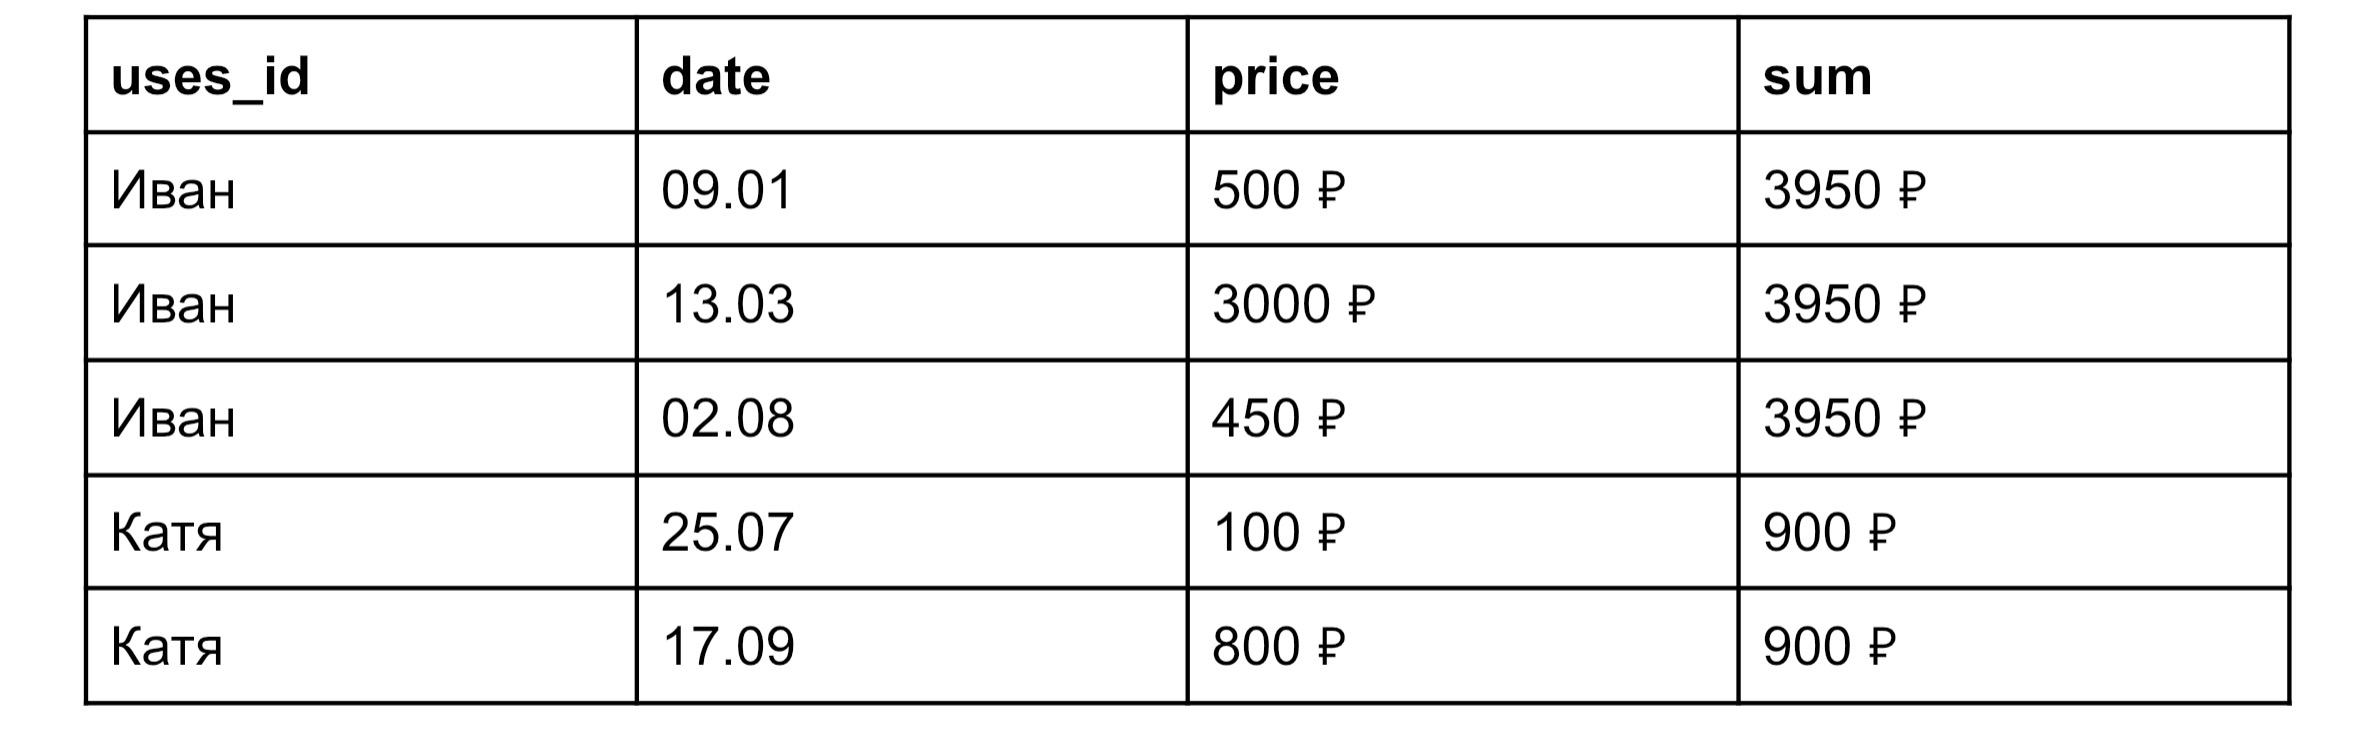

Инструкция ORDER BY определяет столбец, по которому значения внутри окна будут сортироваться при обработке. Например, сортировка по date внутри окна задаётся так:

SELECT user_id, date, price, 
       SUM(price) OVER (PARTITION BY user_id ORDER BY date) AS sum
FROM table


В этом случае для каждой записи в таблице будет вычислена сумма текущей и всех предыдущих покупок пользователя. Результат вычислений будет вписан в столбец sum:

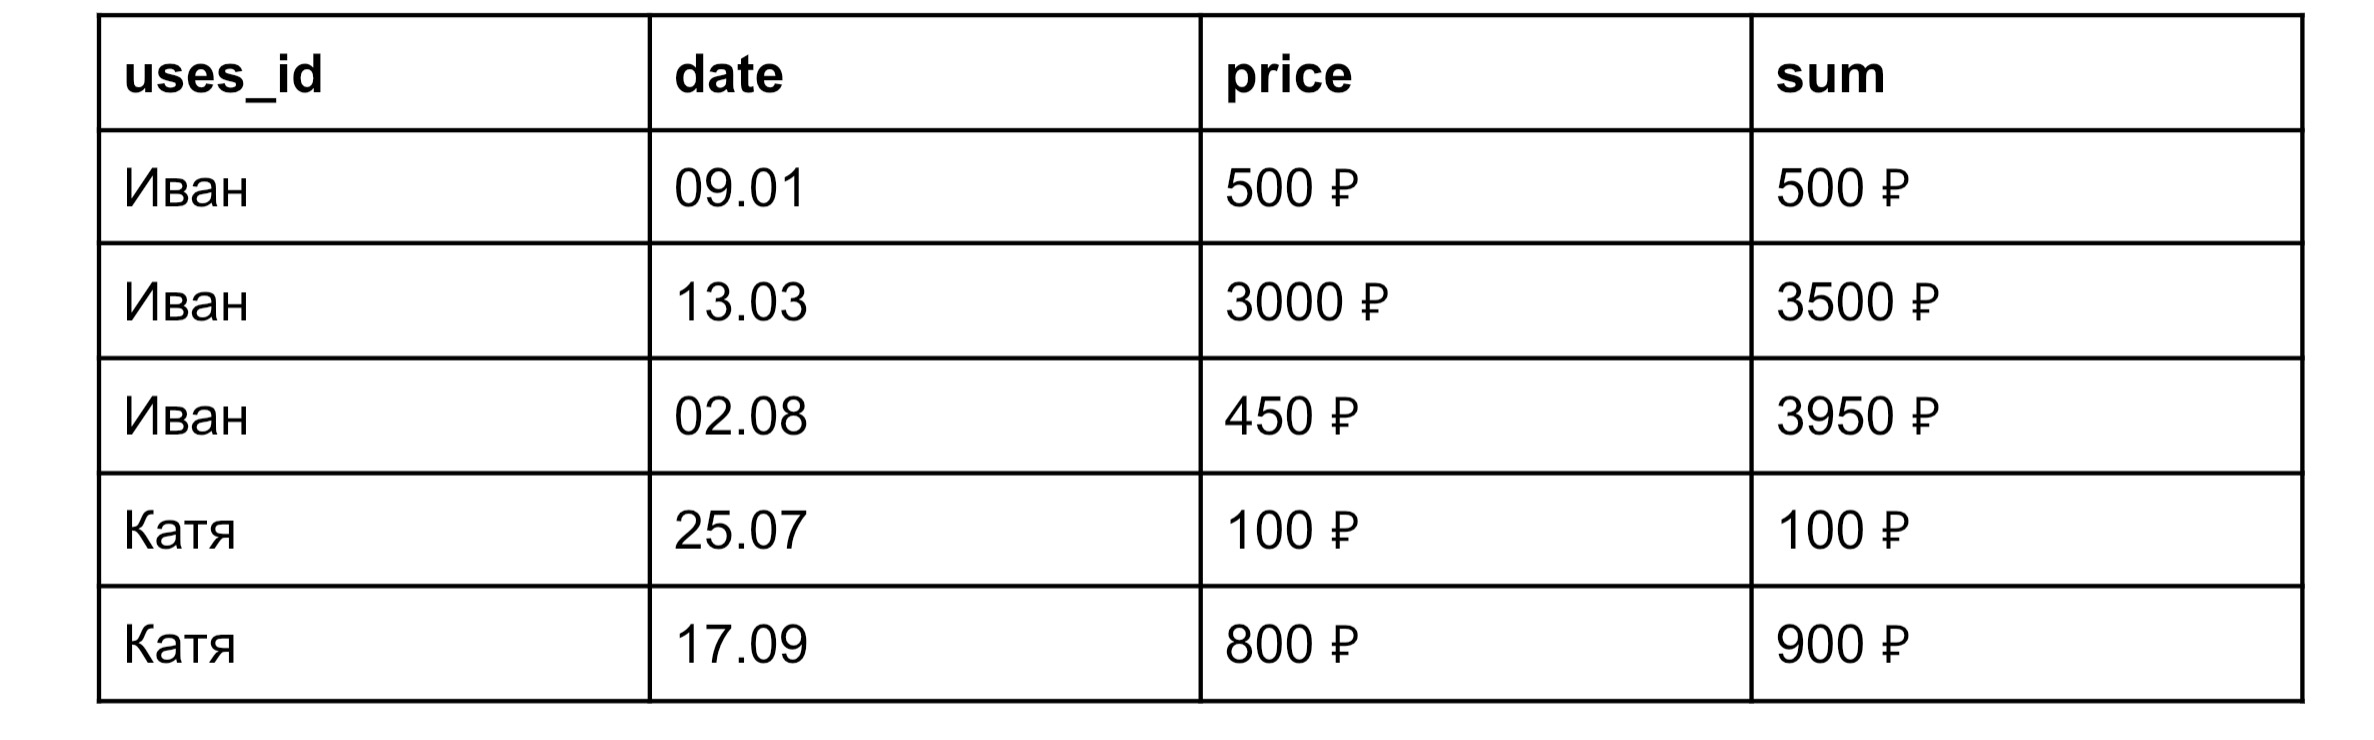



Почему же считается сумма именно текущей и всех предыдущих, а не вообще всех покупок пользователя?

Дело в том, что при использовании оконных функций в паре с агрегирующими для каждой строки определяется так называемая рамка окна — набор строк в её партиции. Если в OVER указать ORDER BY, то по умолчанию рамка будет состоять из всех строк от начала партиции до текущей строки (также в рамку будут включены строки, равные текущей строке по значению, указанному в ORDER BY).

Именно поэтому в нашем примере сумма считается по каждому пользователю нарастающим итогом.

Если же ORDER BY не указывать, то рамка по умолчанию будет состоять из всех строк партиции, т.е. будет посчитана сумма всех покупок каждого пользователя. Также можно не указывать и PARTITION BY — тогда рамкой окна станет вся таблица, и мы просто посчитаем сумму покупок всех пользователей:

SELECT user_id, date, price, 
       SUM(price) OVER () AS sum
FROM table



Инструкции ROWS и RANGE могут дополнительно задавать границы рамки окна и ограничивать диапазон работы функций внутри партиции. Первым аргументом указывается начало рамки, вторым — конец рамки:

SELECT user_id, date, price, 
       SUM(price) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS sum
FROM table


В результате для каждой записи в таблице будет вычислена сумма текущей и предыдущей покупок пользователя, а результат будет снова вписан в столбец sum.

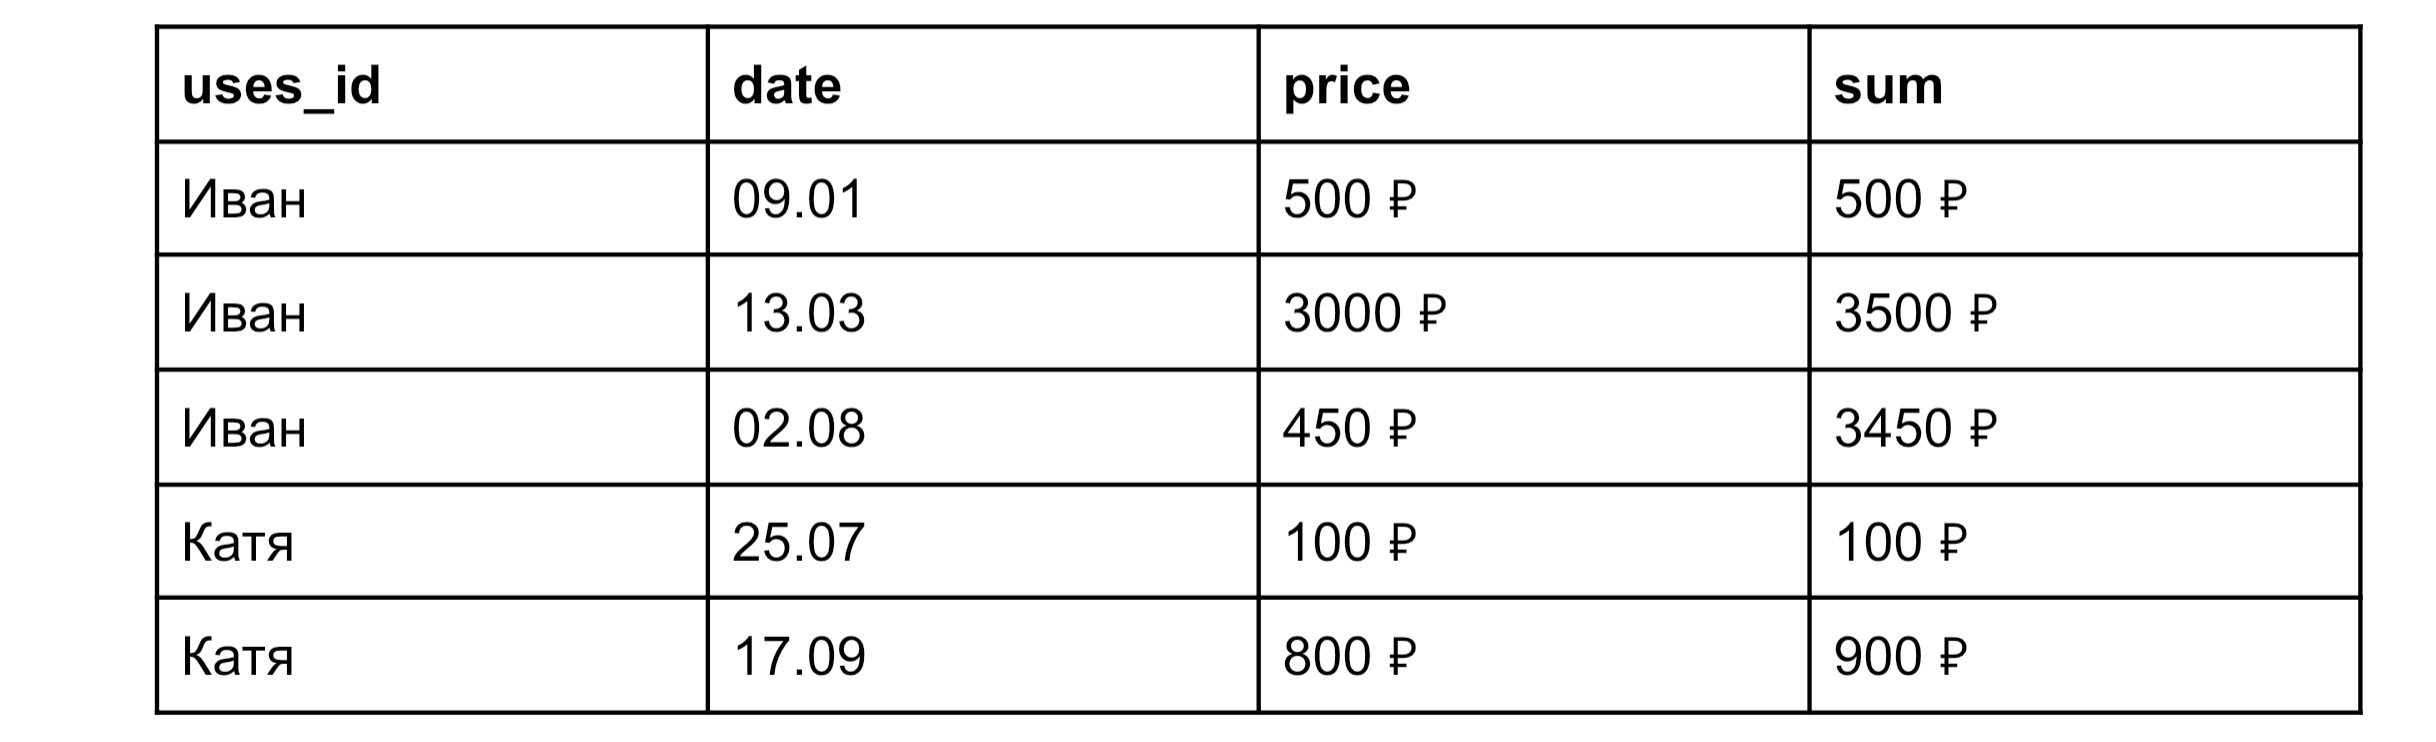

Рамку можно задать в двух режимах:

ROWS — начало и конец рамки определяются строками относительно текущей строки. 
RANGE — начало и конец рамки задаются разницей значений в столбце из ORDER BY.
Начало и конец рамки задаются одним из следующих способов:

UNBOUNDED PRECEDING
значение PRECEDING
CURRENT ROW
значение FOLLOWING
UNBOUNDED FOLLOWING


UNBOUNDED PRECEDING — указывает, что рамка начинается с первой строки партиции.
UNBOUNDED FOLLOWING — указывает, что рамка заканчивается на последней строке партиции.
значение PRECEDING и значение FOLLOWING — указывают, что рамка начинается или заканчивается со сдвигом на заданное число строк относительно текущей строки.
CURRENT ROW — указывает, что рамка начинается или заканчивается на текущей строке.
Рамка всегда начинается с начала рамки и заканчивается концом рамки. Если конец рамки опущен, подразумевается CURRENT ROW. 

По умолчанию рамка определяется так:

RANGE UNBOUNDED PRECEDING


Это равносильно расширенному определению рамки:

RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW


Варианты значение PRECEDING и значение FOLLOWING допускаются только в режиме ROWS.

Например, следующая запись означает создание рамки, включающей 3 строки до текущей и 3 строки после текущей (разумеется, текущая строка тоже включается в рамку):

ROWS BETWEEN 3 PRECEDING AND 3 FOLLOWING


Если в инструкции ORDER BY находится столбец date с типом данных DATE, то рамку окна можно задать следующим образом:

RANGE BETWEEN '3 days' PRECEDING AND '3 days' FOLLOWING


Это будет означать рамку, включающую 3 дня перед и 3 дня после текущей даты (включая текущую дату).

При указании рамки через RANGE обязательным условием является указание только одного столбца в инструкции ORDER BY.

Как и все остальные инструкции, инструкция ROWS/RANGE BETWEEN является необязательной.

Также важно знать, что оконные функции разрешается использовать в запросе только в SELECT и ORDER BY. Во всех остальных операторах, включая WHERE, HAVING и GROUP BY, они запрещены, так как логически выполняются после обычных агрегирующих функций.

Если необходимо отфильтровать или сгруппировать строки после вычисления оконных функций, можно использовать вложенный запрос:

SELECT user_id, date, price, sum
FROM (
    SELECT user_id, date, price, SUM(price) OVER (PARTITION BY user_id ORDER BY date) AS sum
    FROM table
) t
WHERE sum > 1000


Над результатом оконных функций можно производить разные арифметические операции. Также результат оконных функций может выступать в качестве аргумента других функций:

SELECT user_id, date, price, 1.15 * SUM(price) OVER (PARTITION BY user_id ORDER BY date) AS sum
FROM table


SELECT user_id, date, price, ROUND(AVG(price) OVER (PARTITION BY user_id ORDER BY date), 2) AS sum
FROM table


Также при определении инструкций внутри окна можно использовать расчётные поля:

SELECT user_id, date, price, SUM(price) OVER (PARTITION BY DATE_TRUNC('month', date)) AS monthly_sum
FROM table


Сами окна можно также определять через оператор WINDOW, а затем вызывать по алиасу в операторе SELECT:

SELECT SUM(column) OVER w AS sum
FROM table
WHERE ...
GROUP BY ...
HAVING ...
WINDOW w AS (
    PARTITION BY ... 
    ORDER BY ...
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    )
ORDER BY ...
LIMIT ...


В паре с оконными функциями могут использоваться функции разных классов:

1. Агрегирующие функции SUM, AVG, MAX, MIN, COUNT

Внутри окна к таким функциям может применяться ORDER BY. Так, сортировка позволит получить вместо общей суммы нарастающую, а вместо абсолютного максимума — максимум среди значений вплоть до текущего.

2. Ранжирующие функции:

ROW_NUMBER — простая нумерация (1, 2, 3, 4, 5).
RANK — нумерация с учётом повторяющихся значений с пропуском рангов (1, 2, 2, 4, 5).
DENSE_RANK — нумерация с учётом повторяющихся значений без пропуска рангов (1, 2, 2, 3, 4).
Разумеется, для функций ранжирования всегда нужно указывать ORDER BY, иначе они будут работать некорректно.

3. Функции смещения:

LAG, LEAD — значение предыдущей или следующей строки.
FIRST_VALUE, LAST_VALUE — первое или последнее значение в окне.
Для функций смещения определение правил сортировки тоже необходимо.

Со всеми этими функциями мы познакомимся поближе в дальнейших шагах. 



На заметку:

Подробнее об оконных функциях можно почитать здесь.https://www.postgresqltutorial.com/postgresql-window-function/

Также рекомендуем к прочтению статью на Хабре.https://habr.com/ru/post/268983/

А ещё в нашем Telegram-канале есть небольшая шпаргалка по работе с оконными функциями.https://t.me/KarpovCourses/998

## Задача 1.
Начнём знакомство с оконными функциями с простых задач. Для начала поработаем с ранжирующими функциями:

SELECT ROW_NUMBER() OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS row_number
FROM table

SELECT RANK() OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS rank
FROM table

SELECT DENSE_RANK() OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS dense_rank
FROM table


Задание:

Примените оконные функции к таблице products и с помощью ранжирующих функций упорядочьте все товары по цене — от самых дорогих к самым дешёвым. Добавьте в таблицу следующие колонки:

Колонку product_number с порядковым номером товара (функция ROW_NUMBER).
Колонку product_rank с рангом товара с пропусками рангов (функция RANK).
Колонку product_dense_rank с рангом товара без пропусков рангов (функция DENSE_RANK).
Не забывайте указывать в окне сортировку записей — без неё ранжирующие функции могут давать некорректный результат, если таблица заранее не отсортирована. Деление на партиции внутри окна сейчас не требуется. Сортировать записи в результирующей таблице тоже не нужно.

Поля в результирующей таблице: product_id, name, price, product_number, product_rank, product_dense_rank

После того как решите задачу, посмотрите, что в итоге получилось, и проанализируйте результат.

##### ОТВЕТ:

In [ ]:
SELECT product_id,
    name,
    price,
    ROW_NUMBER() OVER (ORDER BY price DESC) AS product_number,
    RANK() OVER (ORDER BY price DESC) AS product_rank,
    DENSE_RANK() OVER (ORDER BY price DESC) AS  product_dense_rank
FROM products


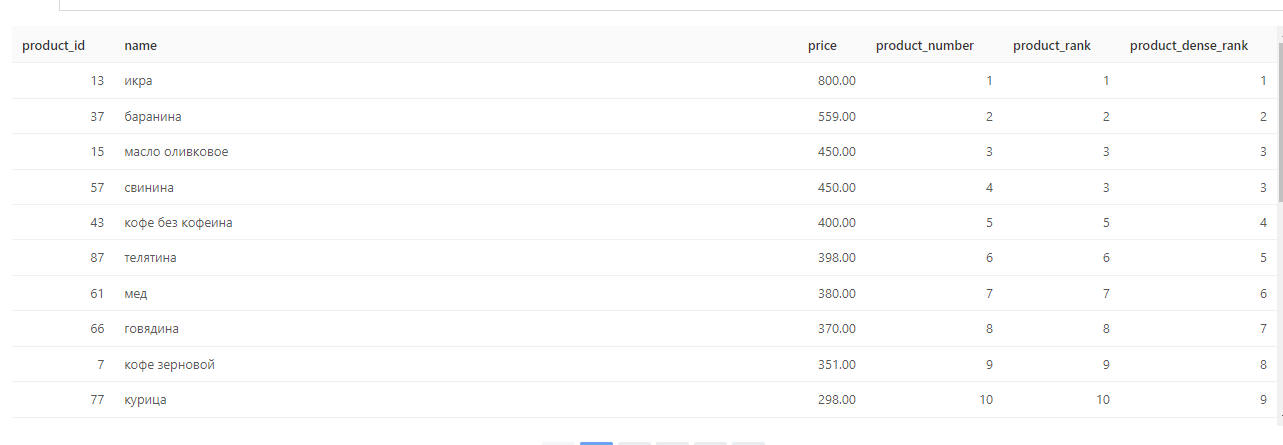

## Задача 2.
С ранжирующими функциями разобрались, теперь давайте научимся в паре с оконными применять и агрегирующие функции:

SELECT SUM(column) OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS sum
FROM table


Задание:

Примените оконную функцию к таблице products и с помощью агрегирующей функции в отдельной колонке для каждой записи проставьте цену самого дорогого товара. Колонку с этим значением назовите max_price. Затем для каждого товара посчитайте долю его цены в стоимости самого дорогого товара — просто поделите одну колонку на другую. Полученные доли округлите до двух знаков после запятой. Колонку с долями назовите share_of_max.

Выведите всю информацию о товарах, включая значения в новых колонках. Результат отсортируйте сначала по убыванию цены товара, затем по возрастанию id товара.

Поля в результирующей таблице: product_id, name, price, max_price, share_of_max

Пояснение:

В этой задаче окном выступает вся таблица. Сортировку внутри окна указывать не нужно.

С результатом агрегации по окну можно проводить арифметические и логические операции. Также к нему можно применять и другие функции — например, округление, как в этой задаче.

##### ОТВЕТ:

In [ ]:
SELECT product_id,
        name,
        price,
        MAX(price) OVER() max_price,
        ROUND((price/MAX(price) OVER()),2) AS share_of_max
FROM products
ORDER BY 3 DESC, 1

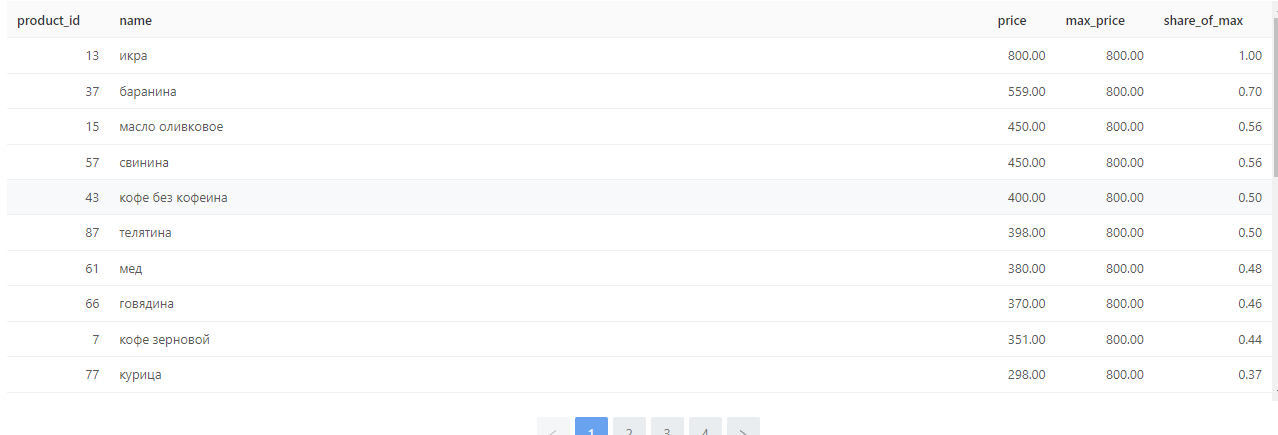

## Задача 3.
А теперь давайте дополним наш предыдущий запрос и укажем инструкцию ORDER BY для окна, работающего в паре с агрегирующей функцией. 

Задание:

Примените две оконные функции к таблице products — одну с агрегирующей функцией MAX, а другую с агрегирующей функцией MIN — для вычисления максимальной и минимальной цены. Для двух окон задайте инструкцию ORDER BY по убыванию цены. Поместите результат вычислений в две колонки max_price и min_price.

Выведите всю информацию о товарах, включая значения в новых колонках. Результат отсортируйте сначала по убыванию цены товара, затем по возрастанию id товара.

Поля в результирующей таблице: product_id, name, price, max_price, min_price

После того как решите задачу, проанализируйте полученный результат и подумайте, почему получились именно такие расчёты. При необходимости вернитесь к первому шагу и ещё раз внимательно ознакомьтесь с тем, как работает рамка окна при указании сортировки.

##### ОТВЕТ:

In [ ]:
SELECT product_id,
        name,
        price,
        MAX(price) OVER(ORDER BY price DESC) AS max_price,
        MIN(price) OVER(ORDER BY price DESC) AS min_price
FROM products
ORDER BY 3 DESC, 1

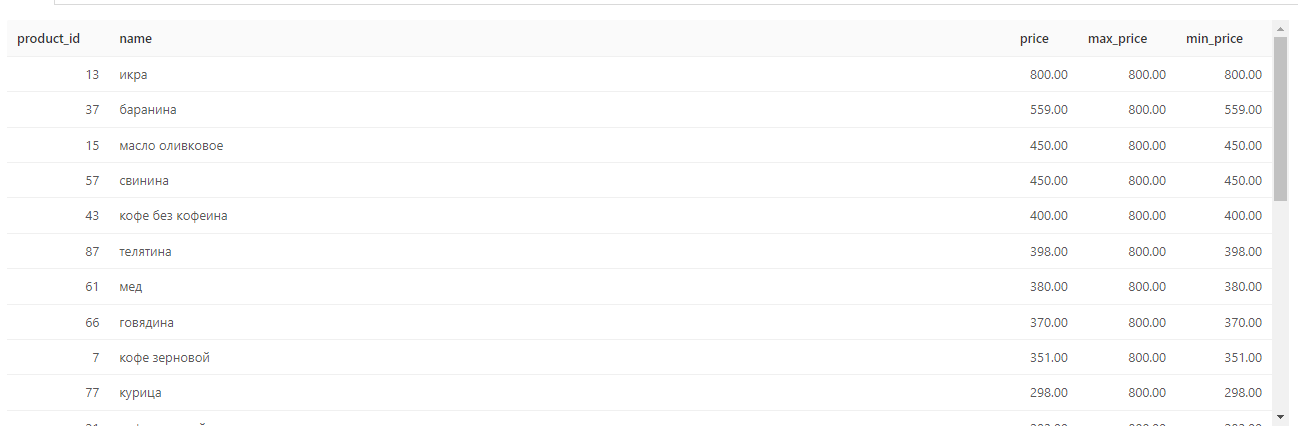

## Задача 4.
Теперь применим оконную функцию с инструкцией ORDER BY для решения практической задачи.

Как мы помним из первого шага, указание сортировки задаёт рамку окна от начала таблицы или партиции до текущей строки. Давайте используем эту особенность для расчёта накопительной суммы, т.е. сделаем так, чтобы для каждой записи возвращался результат сложения её значения со значениями всех предыдущих записей.

Задание:

Сначала на основе таблицы orders сформируйте новую таблицу с общим числом заказов по дням. При подсчёте числа заказов не учитывайте отменённые заказы (их можно определить по таблице user_actions). Колонку с днями назовите date, а колонку с числом заказов — orders_count.

Затем поместите полученную таблицу в подзапрос и примените к ней оконную функцию в паре с агрегирующей функцией SUM для расчёта накопительной суммы числа заказов. Не забудьте для окна задать инструкцию ORDER BY по дате. Колонку с накопительной суммой назовите orders_cum_count. В результате такой операции значение накопительной суммы для последнего дня должно получиться равным общему числу заказов за весь период.

Сортировку результирующей таблицы делать не нужно.

Поля в результирующей таблице: date, orders_count, orders_cum_count

##### ОТВЕТ:

In [ ]:
SELECT date,
    orders_count,
    SUM(orders_count) OVER(ORDER BY date) AS orders_cum_count
FROM
    (SELECT DATE(creation_time) AS date,
            count(order_id) AS orders_count
    FROM orders
    WHERE order_id NOT IN
        (SELECT order_id
        FROM user_actions
        WHERE action = 'cancel_order')
        GROUP BY 1
    )t1

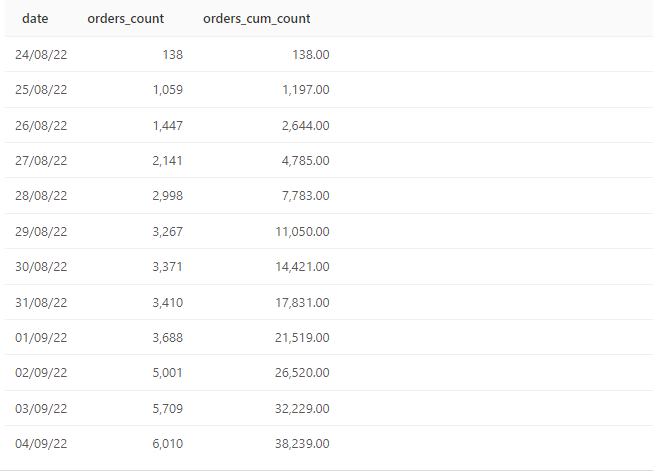

## Задача 5.
В предыдущих заданиях в качестве окна выступала вся таблица. Теперь давайте научимся добавлять в параметры окна деление на партиции и поработаем с инструкцией PARTITION BY.

Задание:

Для каждого пользователя в таблице user_actions посчитайте порядковый номер каждого заказа. Для этого примените оконную функцию ROW_NUMBER к колонке с временем заказа. Не забудьте указать деление на партиции по пользователям и сортировку внутри партиций. Отменённые заказы не учитывайте. Новую колонку с порядковым номером заказа назовите order_number. Результат отсортируйте сначала по возрастанию id пользователя, затем по возрастанию order_number. Добавьте LIMIT 1000.

Поля в результирующей таблице: user_id, order_id, time, order_number

##### ОТВЕТ:

In [ ]:
SELECT user_id,
        order_id,
        time,
        ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY time) AS order_number
FROM user_actions
WHERE order_id not in(SELECT order_id FROM user_actions WHERE action = 'cancel_order')
ORDER BY 1,4
LIMIT 1000

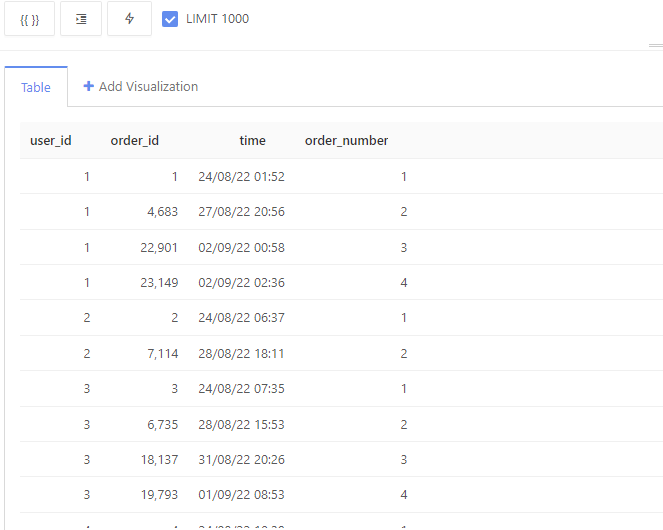

## Задача 6.
Теперь давайте поработаем с функциями смещения — в этом тоже нет ничего сложного:

SELECT LAG(column, 1) OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS lag_value
FROM table

SELECT LEAD(column, 1) OVER (PARTITION BY ... ORDER BY ... ROWS/RANGE BETWEEN ...) AS lead_value
FROM table


В качестве первого аргумента у функций LAG и LEAD указывается колонка со значениями, в качестве второго — то, на какое число строк производить смещение (назад и вперёд соответственно). Второй аргумент можно не указывать, по умолчанию его значение равно 1.

На заметку:

Подробнее про функции LAG и LEAD можно почитать здесь и здесь.

Задание:

Дополните запрос из предыдущего задания и с помощью оконной функции для каждого заказа каждого пользователя рассчитайте, сколько времени прошло с момента предыдущего заказа. 

Для этого сначала в отдельном столбце с помощью LAG сделайте смещение по столбцу time на одно значение назад. Столбец со смещёнными значениями назовите time_lag. Затем отнимите от каждого значения в колонке time новое значение со смещением (либо можете использовать уже знакомую функцию AGE). Колонку с полученным интервалом назовите time_diff. Менять формат отображения значений не нужно, они должны иметь примерно следующий вид:

3 days, 12:18:22


По-прежнему не учитывайте отменённые заказы. Также оставьте в запросе порядковый номер каждого заказа, рассчитанный на прошлом шаге. Результат отсортируйте сначала по возрастанию id пользователя, затем по возрастанию порядкового номера заказа. Добавьте LIMIT 1000.

Поля в результирующей таблице: user_id, order_id, time, order_number, time_lag, time_diff

Пояснение:

Не забывайте про деление на партиции и сортировку внутри окна.

Также обратите внимание, что в результате смещения для первых заказов каждого пользователя в колонке time_lag получились пропущенные значения. Для таких записей функция не нашла предыдущих значений и вернула NULL. То же самое произошло в записях пользователей с одним заказом — внутри партиции с одной записью просто некуда сдвигаться.

Образовавшиеся пропущенные значения убирать из результата не нужно.

##### ОТВЕТ:

In [ ]:
SELECT user_id,
        order_id,
        time,
        ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY time) AS order_number,
        LAG(time,1) OVER (PARTITION BY user_id ORDER BY time) AS time_lag,
        (time - LAG(time,1) OVER (PARTITION BY user_id ORDER BY time)) AS time_diff
        
FROM user_actions
WHERE order_id not in(SELECT order_id FROM user_actions WHERE action = 'cancel_order')
ORDER BY 1,4
LIMIT 1000

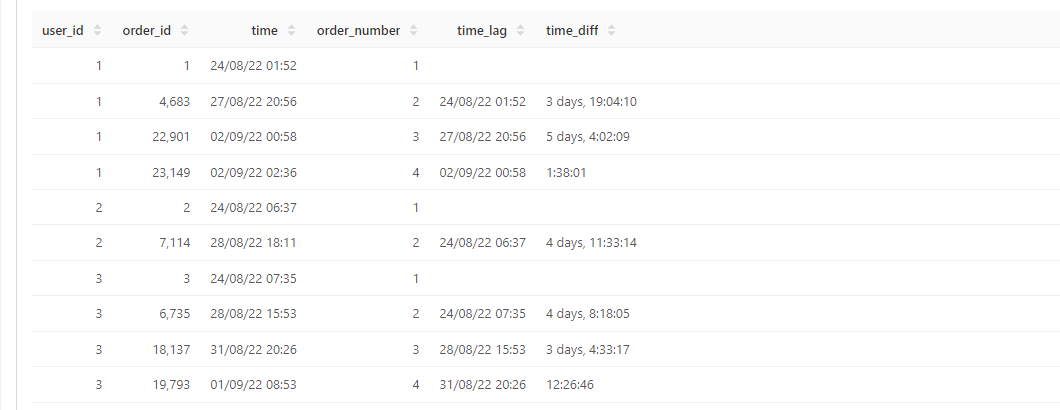

## Задача 7.
Давайте для полноты картины посчитаем, сколько в среднем времени проходит между заказами каждого пользователя.

Задание:

На основе запроса из предыдущего задания для каждого пользователя рассчитайте, сколько в среднем времени проходит между его заказами. Не считайте этот показатель для тех пользователей, которые за всё время оформили лишь один заказ. Полученное среднее значение (интервал) переведите в часы, а затем округлите до целого числа. Колонку со средним значением часов назовите hours_between_orders. Результат отсортируйте по возрастанию id пользователя.

Добавьте LIMIT 1000.

Поля в результирующей таблице: user_id, hours_between_orders

Пояснение:

Чтобы перевести среднее значение интервала в часы, необходимо извлечь из него количество секунд, а затем поделить это значение на количество секунд в одном часе. Для извлечения количества секунд из интервала можно воспользоваться следующей конструкцией:

SELECT EXTRACT(epoch FROM INTERVAL '3 days, 1:21:32')

Результат:
177325


Функция EXTRACT работает аналогично функции DATE_PART, которую мы рассматривали на прошлых уроках, но имеет несколько иной синтаксис. Попробуйте воспользоваться функцией EXTRACT в этой задаче.

В результате всех расчётов для каждого пользователя у вас должно получиться целое число часов, которое в среднем проходит между заказами. Подумайте, как убрать из данных пользователей с одним заказом.

Повторять все предыдущие оконные функции из предыдущего запроса не обязательно — оставьте только самое необходимое.

На заметку:

Подробнее про функцию EXTRACT можно почитать здесь.

##### ОТВЕТ:

In [ ]:
SELECT user_id,
    ROUND(AVG(EXTRACT(EPOCH FROM (time_diff)))/3600)  AS hours_between_orders
FROM
    (SELECT user_id,
            order_id,
            time,
            ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY time) AS order_number,
            LAG(time,1) OVER (PARTITION BY user_id ORDER BY time) AS time_lag,
            (time - LAG(time,1) OVER (PARTITION BY user_id ORDER BY time)) AS time_diff
            
    FROM user_actions
    WHERE order_id not in(SELECT order_id FROM user_actions WHERE action = 'cancel_order')
    ) t1
WHERE time_lag IS NOT NULL
GROUP BY 1
ORDER BY 1
LIMIT 1000




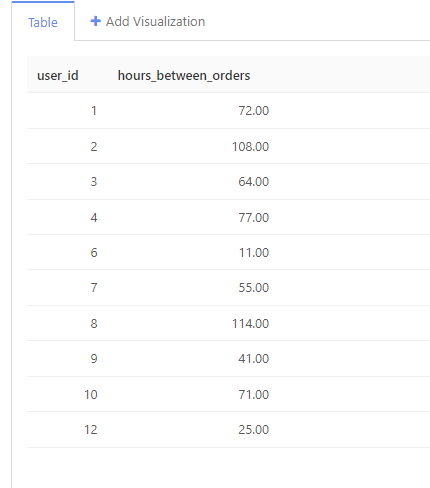

## Задача 8.
Пришло время немного поработать с инструкцией ROWS BETWEEN, которую мы подробно рассматривали на первом шаге. Напомним, что начало и конец рамки задаются следующими способами:

UNBOUNDED PRECEDING
значение PRECEDING
CURRENT ROW
значение FOLLOWING
UNBOUNDED FOLLOWING


Вот ещё один пример указания границ рамки:

SELECT SUM(column_3) OVER (PARTITION BY column_1 
                           ORDER BY column_2 
                           ROWS BETWEEN UNBOUNDED PRECEDING AND 3 FOLLOWING) AS sum
FROM table


Но в каких задачах бывает полезно указывать рамку для расчётов? Первое, что приходит на ум любому аналитику, — скользящее среднее.

Скользящее среднее — это показатель, который вычисляется в каждой точке временного ряда как среднее значение за N предыдущих периодов (дней, недель, месяцев и т.д. в зависимости от уровня агрегации данных). Скользящее среднее как бы перемещается по временному ряду и каждый раз учитывает фиксированное количество значений — для проведения таких расчётов как раз и нужна рамка окна, которая задаётся инструкцией ROWS BETWEEN.

Давайте попробуем провести такие расчёты на наших данных.

Задание:

Сначала на основе таблицы orders сформируйте новую таблицу с общим числом заказов по дням. Вы уже делали это в одной из предыдущих задач. При подсчёте числа заказов не учитывайте отменённые заказы (их можно определить по таблице user_actions). Колонку с числом заказов назовите orders_count.

Затем поместите полученную таблицу в подзапрос и примените к ней оконную функцию в паре с агрегирующей функцией AVG для расчёта скользящего среднего числа заказов. Скользящее среднее для каждой записи считайте по трём предыдущим дням. Подумайте, как правильно задать границы рамки, чтобы получить корректные расчёты.

Полученные значения скользящего среднего округлите до двух знаков после запятой. Колонку с рассчитанным показателем назовите moving_avg. Сортировку результирующей таблицы делать не нужно.

Поля в результирующей таблице: date, orders_count, moving_avg

Пояснение:

При решении задачи можете пробовать разные границы рамки и проверять себя вручную. Важно для каждой даты учесть в расчётах именно 3 предыдущих дня.

Заполнять пропущенные значения в этой задаче не нужно. Подумайте, почему они могли появиться.

##### ОТВЕТ:

In [ ]:
SELECT date,
    orders_count,
    ROUND(AVG(orders_count) OVER (ORDER BY date ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING),2) AS moving_avg
 FROM
    (SELECT DATE(creation_time) AS date,
            count(order_id) AS orders_count
    FROM orders
    WHERE order_id NOT IN
        (SELECT order_id
        FROM user_actions
        WHERE action = 'cancel_order')
        GROUP BY 1
    )t1

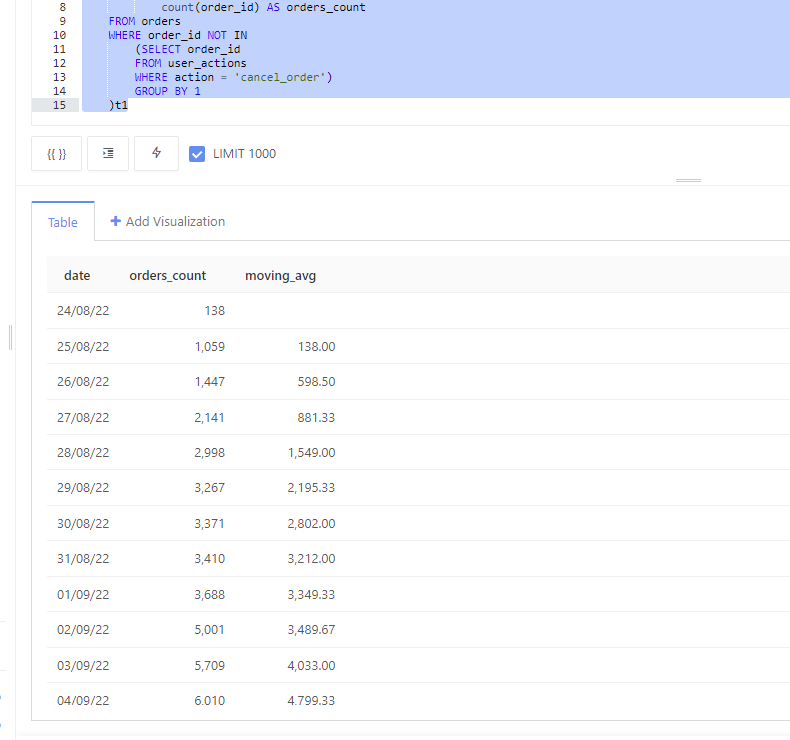

## Задача 9.
Теперь научимся вместе с оконными функциями применять конструкцию CASE. Пример такой записи:

SELECT
    CASE
    WHEN SUM(column) OVER (...) > 100 THEN 'above 100'
    WHEN SUM(column) OVER (...) < 100 THEN 'below 100'
    ELSE 'equal 100'
    END AS sum_case
FROM table


Задание:

Отметьте в отдельной таблице тех курьеров, которые доставили в сентябре заказов больше, чем в среднем все курьеры.

Сначала для каждого курьера в таблице courier_actions рассчитайте общее количество доставленных в сентябре заказов. Затем в отдельном столбце с помощью оконной функции укажите, сколько в среднем заказов доставили в этом месяце все курьеры. После этого сравните число заказов, доставленных каждым курьером, со средним значением в новом столбце. Если курьер доставил больше заказов, чем в среднем все курьеры, то в отдельном столбце с помощью CASE укажите число 1, в противном случае укажите 0.

Колонку с результатом сравнения назовите is_above_avg, колонку с числом доставленных заказов каждым курьером — delivered_orders, а колонку со средним значением — avg_delivered_orders. При расчёте среднего значения округлите его до двух знаков после запятой. Результат отсортируйте по возрастанию id курьера.

Поля в результирующей таблице: courier_id, delivered_orders, avg_delivered_orders, is_above_avg

##### ОТВЕТ:

In [ ]:
SELECT courier_id,
    COUNT(order_id) AS delivered_orders,
    ROUND(AVG(COUNT(order_id)) OVER(),2) AS avg_delivered_orders,
    CASE
    WHEN AVG(COUNT(order_id)) OVER() < COUNT(order_id)  THEN 1
    ELSE 0
    END AS is_above_avg
FROM courier_actions
WHERE action ='deliver_order' AND time BETWEEN '2022-09-01' AND '2022-09-30'
GROUP BY 1
ORDER BY 1

In [ ]:
# из подсказки после решения
SELECT courier_id,
    delivered_orders,
    ROUND(AVG(delivered_orders) OVER (), 2) AS avg_delivered_orders,
    CASE WHEN delivered_orders > ROUND(AVG(delivered_orders) OVER (), 2)
    THEN 1 ELSE 0 END AS is_above_avg
FROM ( SELECT courier_id, COUNT(order_id) AS delivered_orders
      FROM courier_actions
      WHERE action='deliver_order' AND DATE_PART('month', time)=9
      GROUP BY courier_id
     ) t
ORDER BY courier_id

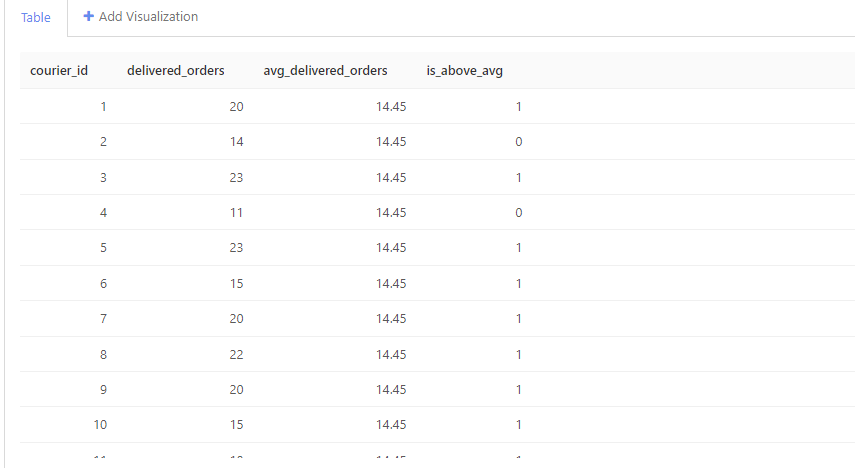

## Задача 10.
В этом задании рассмотрим ещё более продвинутый функционал и научимся вместе с оконными функциями применять оператор FILTER, с которым мы уже работали на прошлых уроках.

Если к определению оконной функции добавить предложение FILTER, то в окно попадут только те входные строки, для которых условие фильтра будет вычислено как истинное.

При этом предложение FILTER допускается только для агрегирующих оконных функций.

В общем виде вся конструкция выглядит так:

SELECT agg_function(column) FILTER (WHERE [condition]) OVER (...)
FROM table


Пример:

SELECT SUM(column_1) FILTER (WHERE column_2 > 100) OVER (PARTITION BY column_3 ORDER BY column_4) AS sum
FROM table


Задание:

Примените оконную функцию к таблице products и с помощью агрегирующей функции в отдельной колонке для каждой записи проставьте среднюю цену всех товаров. Колонку с этим значением назовите avg_price. Затем с помощью оконной функции и оператора FILTER в отдельной колонке рассчитайте среднюю цену товаров без учёта самого дорогого. Колонку с этим средним значением назовите avg_price_filtered. Полученные средние значения в колонках avg_price и avg_price_filtered округлите до двух знаков после запятой.

Выведите всю информацию о товарах, включая значения в новых колонках. Результат отсортируйте сначала по убыванию цены товара, затем по возрастанию id товара.

Поля в результирующей таблице: product_id, name, price, avg_price, avg_price_filtered

Пояснение:

В этой задаче окном снова выступает вся таблица. Сортировку внутри окна указывать не нужно.

##### ОТВЕТ:

In [ ]:
# Залипуха )))
SELECT product_id,
        name, price,
        ROUND(AVG(price) OVER (),2) AS avg_price,
        ROUND(AVG(price) FILTER(WHERE price != 800) OVER (),2) AS avg_price_filtered
FROM products
ORDER BY 3 DESC, 1

In [ ]:
SELECT product_id,
        name, price,
        ROUND(AVG(price) OVER (),2) AS avg_price,
        ROUND(AVG(price) FILTER(WHERE price != (SELECT MAX(price) FROM products)) OVER (),2) AS avg_price_filtered
FROM products
ORDER BY 3 DESC, 1

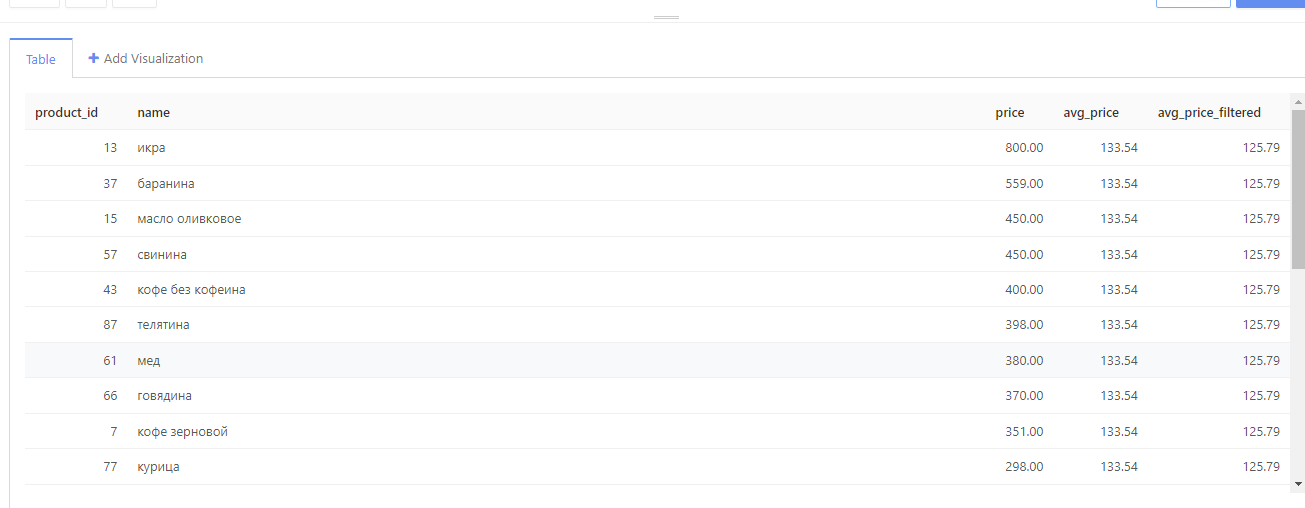

## * Задача 11.
А теперь ещё одна задача на фильтрацию по окну — в этот раз посложнее.

Задание:

Для каждой записи в таблице user_actions с помощью оконных функций и предложения FILTER посчитайте, сколько заказов сделал и сколько отменил каждый пользователь на момент совершения нового действия.

Иными словами, для каждого пользователя в каждый момент времени посчитайте две накопительные суммы — числа оформленных и числа отменённых заказов. Если пользователь оформляет заказ, то число оформленных им заказов увеличивайте на 1, если отменяет — увеличивайте на 1 количество отмен.

Колонки с накопительными суммами числа оформленных и отменённых заказов назовите соответственно created_orders и canceled_orders. На основе этих двух колонок для каждой записи пользователя посчитайте показатель cancel_rate, т.е. долю отменённых заказов в общем количестве оформленных заказов. Значения показателя округлите до двух знаков после запятой. Колонку с ним назовите cancel_rate.

В результате у вас должны получиться три новые колонки с динамическими показателями, которые изменяются во времени с каждым новым действием пользователя.

В результирующей таблице отразите все колонки из исходной таблицы вместе с новыми колонками. Отсортируйте результат по колонкам user_id, order_id, action, time — по возрастанию значений в каждой. Добавьте LIMIT 1000.

Поля в результирующей таблице:

user_id, order_id, action, time, created_orders, canceled_orders, cancel_rate

Пояснение:

Подумайте, как правильно задать окна и какие фильтры в них нужно указать.

Не забудьте изменить тип данных при делении двух целочисленных значений.

##### ОТВЕТ:

In [ ]:
SELECT user_id,
        order_id,
        action,
        time,
        COUNT(order_id) FILTER(WHERE action = 'create_order') OVER(PARTITION BY user_id ORDER BY time) AS created_orders,
        COUNT(order_id) FILTER(WHERE action = 'cancel_order') OVER(PARTITION BY user_id ORDER BY time) AS canceled_orders,
        ROUND((COUNT(order_id) FILTER(WHERE action = 'cancel_order') OVER(PARTITION BY user_id ORDER BY time):: DECIMAL/
        COUNT(order_id) FILTER(WHERE action = 'create_order') OVER(PARTITION BY user_id ORDER BY time)),2) AS cancel_rate
FROM user_actions
ORDER BY 1,2,3,4
LIMIT 1000


In [ ]:
# Из подсказки после решения
SELECT user_id,
        order_id,
        action,
        time,
        created_orders,
        canceled_orders,
        ROUND(canceled_orders::decimal / created_orders, 2) AS cancel_rate
FROM ( SELECT user_id,
          order_id,
          action,
          time,
          COUNT(order_id) FILTER (WHERE action!='cancel_order') OVER (PARTITION BY user_id ORDER BY time) AS created_orders,
          COUNT(order_id) FILTER (WHERE action='cancel_order') OVER (PARTITION BY user_id ORDER BY time) AS canceled_orders
      FROM user_actions ) t 
ORDER BY user_id, order_id, action, time
LIMIT 1000

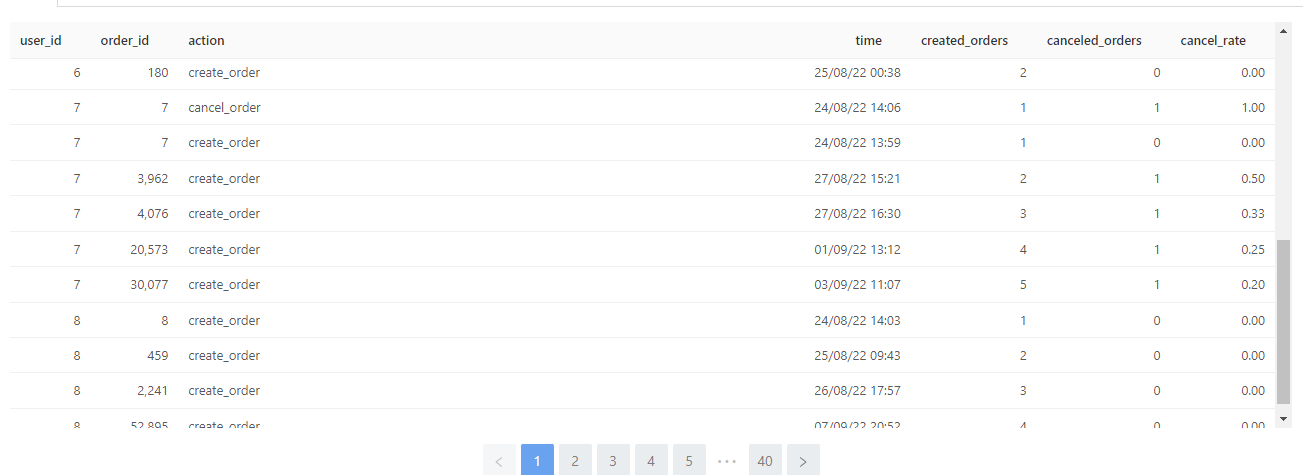

## Задача 12.
Задание:

Из таблицы courier_actions отберите топ 10% курьеров по количеству доставленных за всё время заказов. Выведите id курьеров, количество доставленных заказов и порядковый номер курьера в соответствии с числом доставленных заказов.

У курьера, доставившего наибольшее число заказов, порядковый номер должен быть равен 1, а у курьера с наименьшим числом заказов —  числу, равному десяти процентам от общего количества курьеров в таблице courier_actions.

При расчёте номера последнего курьера округляйте значение до целого числа.

Колонки с количеством доставленных заказов и порядковым номером назовите соответственно orders_count и courier_rank. Результат отсортируйте по возрастанию порядкового номера курьера.

Поля в результирующей таблице: courier_id, orders_count, courier_rank 

Пояснение:

Если у двух курьеров оказалось одинаковое число доставленных заказов, более высокий ранг мы присвоим курьеру с меньшим id. Например, если у курьеров с id 10 и 80 оказалось максимальное число заказов, то первый ранг мы присвоим курьеру с id 10,

##### ОТВЕТ:

In [ ]:
# Залипуха
SELECT courier_id,
        orders_count,
        courier_rank
FROM
    (SELECT courier_id,
            COUNT(order_id) AS orders_count,
            ROW_NUMBER() OVER( ORDER BY COUNT(order_id) DESC, courier_id ) AS courier_rank
    FROM courier_actions
    WHERE action = 'deliver_order'
    GROUP BY 1
    ) t
WHERE  courier_rank < 284
ORDER BY 3,1

In [ ]:
SELECT courier_id,
        orders_count,
        courier_rank
FROM
    (SELECT courier_id,
            COUNT(order_id) AS orders_count,
            ROW_NUMBER() OVER( ORDER BY COUNT(order_id) DESC, courier_id ) AS courier_rank
    FROM courier_actions
    WHERE action = 'deliver_order'
    GROUP BY 1
    ) t
ORDER BY 3,1
LIMIT (SELECT ROUND(COUNT(DISTINCT courier_id) * 0.1) FROM courier_actions)


In [ ]:
# МОЕ ЛУЧШЕЕ!!
SELECT courier_id,
    COUNT(order_id) AS orders_count,
    ROW_NUMBER() OVER( ORDER BY COUNT(order_id) DESC, courier_id ) AS courier_rank
FROM courier_actions
WHERE action = 'deliver_order'
GROUP BY 1
ORDER BY 3,1
LIMIT (SELECT ROUND(COUNT(DISTINCT courier_id) * 0.1) FROM courier_actions)

In [ ]:
# Чужое
SELECT courier_id, orders_count, ROW_NUMBER() OVER(ORDER BY orders_count DESC, courier_id) AS courier_rank
FROM (SELECT courier_id, COUNT(order_id) AS orders_count
FROM courier_actions
WHERE action = 'deliver_order'
GROUP BY courier_id) t1
LIMIT (SELECT ROUND(COUNT(DISTINCT courier_id) * 0.1) FROM courier_actions)

In [ ]:
# Из подсказки после решения
WITH courier_count AS ( SELECT COUNT(DISTINCT courier_id) FROM courier_actions )
SELECT courier_id,
    orders_count,
    courier_rank
FROM ( SELECT courier_id,
          COUNT(distinct order_id) AS orders_count,
          row_number() OVER (ORDER BY COUNT(distinct order_id) DESC, courier_id) AS courier_rank
      FROM courier_actions WHERE action='deliver_order'
      GROUP BY courier_id
      ORDER BY orders_count DESC, courier_id
     ) as t1
WHERE courier_rank <= ROUND((SELECT * FROM courier_count)*0.1)

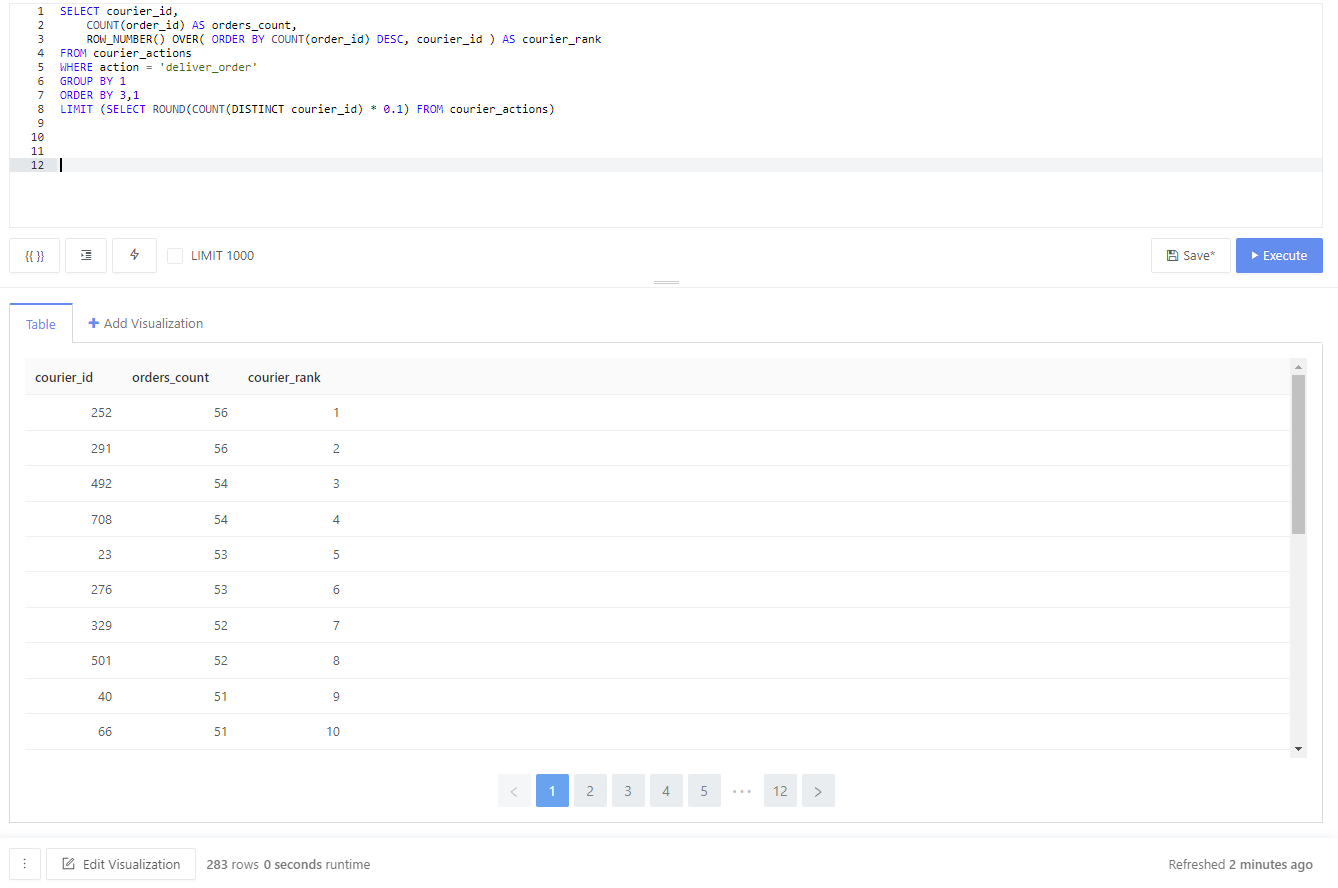

## Задача 13.
Задание:

С помощью оконной функции отберите из таблицы courier_actions всех курьеров, которые работают в нашей компании 10 и более дней. Также рассчитайте, сколько заказов они уже успели доставить за всё время работы.

Будем считать, что наш сервис предлагает самые выгодные условия труда и поэтому за весь анализируемый период ни один курьер не уволился из компании. Возможные перерывы между сменами не учитывайте — для нас важна только разница во времени между первым действием курьера и текущей отметкой времени. Текущей отметкой времени, относительно которой необходимо рассчитывать продолжительность работы курьера, считайте время последнего действия в таблице courier_actions. Учитывайте только целые дни, прошедшие с первого выхода курьера на работу (часы и минуты не учитывайте).

В результат включите три колонки: id курьера, продолжительность работы в днях и число доставленных заказов. Две новые колонки назовите соответственно days_employed и delivered_orders. Результат отсортируйте сначала по убыванию количества отработанных дней, затем по возрастанию id курьера.

Поля в результирующей таблице: courier_id, days_employed, delivered_orders

Пояснение: 

Для решения задачи помимо оконной функции вам могут пригодиться функция DATE_PART и оператор FILTER.

Число дней, которые отработал курьер, — это количество дней, прошедших с первого принятого заказа до времени последней записи в таблице courier_actions.



##### ОТВЕТ:

In [ ]:
# Не приняло
SELECT courier_id,
        days_employed,
        COUNT(order_id) AS delivered_orders
FROM
    (SELECT courier_id,
        MIN(time) OVER (PARTITION BY courier_id) AS start_time,
        DATE_PART('day', AGE((SELECT MAX(time) FROM courier_actions), MIN(time) OVER(PARTITION BY courier_id))) AS days_employed,
        order_id
    FROM courier_actions
    WHERE action = 'deliver_order'

    )t
WHERE days_employed >9
GROUP BY 1,2
ORDER BY 2 DESC, 1

In [ ]:
# Не приняло
SELECT courier_id,
        days_employed,
        COUNT(order_id) AS delivered_orders
FROM
    (SELECT courier_id,
        MIN(time) OVER (PARTITION BY courier_id) AS start_time,
        DATE_PART('day', (SELECT MAX(time) FROM courier_actions)- MIN(time) OVER(PARTITION BY courier_id)) AS days_employed,
        order_id
    FROM courier_actions
    WHERE action = 'deliver_order'
    )t
WHERE days_employed >9
GROUP BY 1,2
ORDER BY 2 DESC, 1

In [ ]:
# МОЕ !!! КОТОРОЕ ПРИНЯЛО LMS
SELECT courier_id,
        days_employed,
        delivered_orders
FROM
    (SELECT DISTINCT courier_id,
        DATE_PART('day', (SELECT MAX(time) FROM courier_actions)- MIN(time) OVER(PARTITION BY courier_id)) AS days_employed,
        COUNT(order_id) FILTER(WHERE action = 'deliver_order') OVER (PARTITION BY courier_id) AS delivered_orders
    FROM courier_actions
    )t
WHERE days_employed >9
ORDER BY 2 DESC, 1

In [ ]:
# Из подсказки после решения
SELECT courier_id,
    days_employed,
    delivered_orders
FROM ( SELECT courier_id,
          delivered_orders,
          DATE_PART('days', MAX(max_time) OVER() - min_time) AS days_employed
      FROM ( SELECT courier_id,
                COUNT(DISTINCT order_id) FILTER (WHERE action='deliver_order') AS delivered_orders,
                MIN(time) AS min_time,
                MAX(time) AS max_time
            FROM courier_actions
            GROUP BY courier_id
           ) t1
     ) t2
WHERE days_employed >= 10
ORDER BY days_employed DESC, courier_id

In [ ]:
# ЧУЖОЕ
WITH last_date AS (SELECT MAX(time) FROM courier_actions),
t AS (
    SELECT
        courier_id,
        DATE_PART('day', (SELECT * FROM last_date) - MIN(time) OVER (PARTITION BY courier_id)) AS days_employed,
        COUNT(order_id) FILTER (where action = 'deliver_order') OVER (partition by courier_id) delivered_orders
    from courier_actions)

SELECT
    DISTINCT courier_id,
    days_employed,
    delivered_orders
FROM t
WHERE days_employed >= 10
order by days_employed desc, courier_id


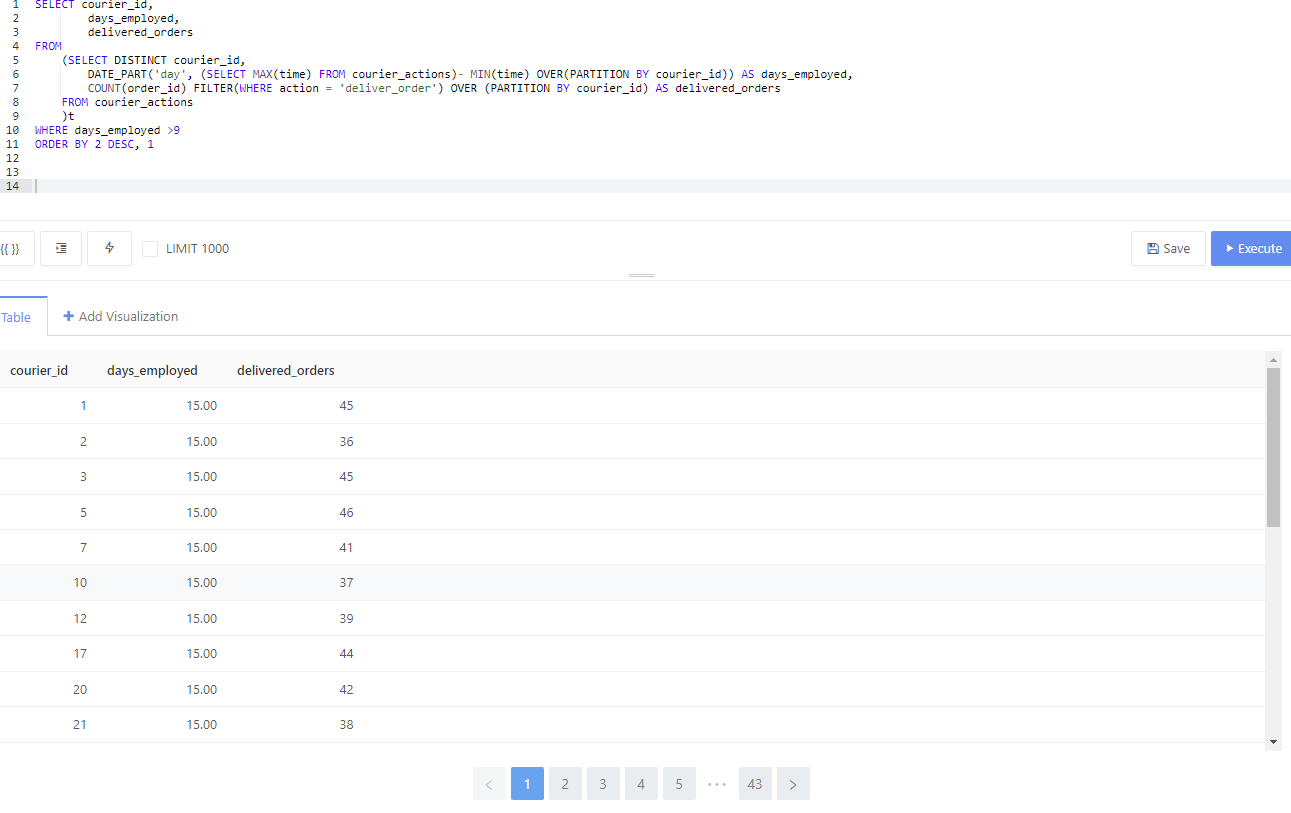

## Задача 14.
Задание:

На основе информации в таблицах orders и products рассчитайте стоимость каждого заказа, ежедневную выручку сервиса и долю стоимости каждого заказа в ежедневной выручке, выраженную в процентах. В результат включите следующие колонки: id заказа, время создания заказа, стоимость заказа, выручку за день, в который был совершён заказ, а также долю стоимости заказа в выручке за день, выраженную в процентах.

При расчёте долей округляйте их до трёх знаков после запятой.

Результат отсортируйте сначала по убыванию даты совершения заказа (именно даты, а не времени), потом по убыванию доли заказа в выручке за день, затем по возрастанию id заказа.

При проведении расчётов отменённые заказы не учитывайте.

Поля в результирующей таблице:

order_id, creation_time, order_price, daily_revenue, percentage_of_daily_revenue

##### ОТВЕТ:

In [ ]:
# Из подсказки после решения
SELECT order_id,
    creation_time,
    order_price,
    SUM(order_price) OVER(PARTITION BY DATE(creation_time)) AS daily_revenue,
    ROUND(100 * order_price::decimal / SUM(order_price) OVER(PARTITION BY DATE(creation_time)), 3) AS percentage_of_daily_revenue
FROM ( SELECT order_id,
            creation_time,
            SUM(price) AS order_price
        FROM ( SELECT order_id,
                    creation_time,
                    product_ids,
                    UNNEST(product_ids) AS product_id
                FROM orders
                WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action='cancel_order')
            ) t3
        LEFT JOIN products USING(product_id)
        GROUP BY order_id, creation_time
    ) t
ORDER BY DATE(creation_time) DESC, percentage_of_daily_revenue DESC, order_id

In [ ]:
# ЧУЖОЕ
SELECT order_id,
    creation_time,
    order_price,
    SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue,
    ROUND((SUM(order_price) OVER(PARTITION BY order_id) / SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time))) * 100, 3) AS percentage_of_daily_revenue
FROM
    (SELECT l.order_id AS order_id,
            l.creation_time AS creation_time,
            SUM(r.price) AS order_price
    FROM
        (SELECT order_id, creation_time, unnest(product_ids) AS product_id
        FROM orders
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')) l
    LEFT JOIN products r 
    ON l.product_id = r.product_id
    GROUP BY order_id, creation_time) t1
ORDER BY creation_time::DATE DESC, percentage_of_daily_revenue DESC, order_id


In [ ]:
# МОЕ НО ЛМС НЕ ПРИНИАЕТ... СОРТИРОВКА НЕ ТА
SELECT  DISTINCT(order_id),
        creation_time,
        SUM(price) OVER(PARTITION BY order_id) AS order_price,
        SUM(price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue,
        ROUND((SUM(price) OVER(PARTITION BY order_id)/(SUM(price) OVER(PARTITION BY DATE_PART('day', creation_time))))*100 ,3) AS percentage_of_daily_revenue
FROM 
    (SELECT creation_time,order_id,
            UNNEST(product_ids) AS product_id
    FROM orders
    WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
    ) AS l
JOIN products AS r
USING (product_id)
ORDER BY 2 DESC, 5 DESC, 1


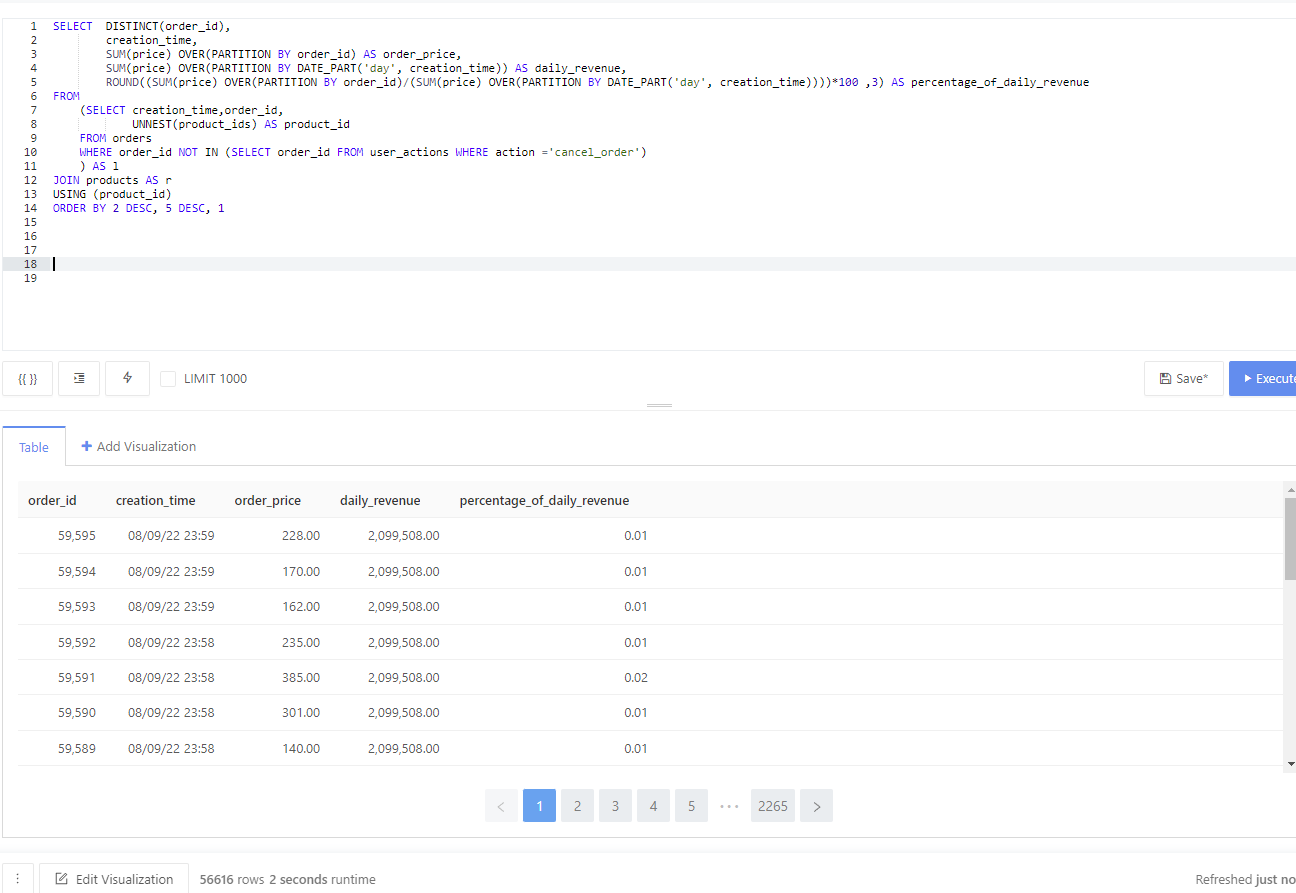

In [ ]:
# МОЕ принимает)))
SELECT  order_id,
        creation_time,
        order_price,
        SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue,
        ROUND((order_price/(SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time))))*100 ,3) AS percentage_of_daily_revenue
FROM 
    (SELECT order_id,
            creation_time,
            SUM(price)  AS order_price
    FROM 
        (SELECT creation_time,order_id,
                UNNEST(product_ids) AS product_id
        FROM orders
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
        ) AS l
    JOIN products AS r
    USING (product_id)
    GROUP BY 1,2
    ) t
ORDER BY DATE(creation_time) DESC, 5 DESC, 1

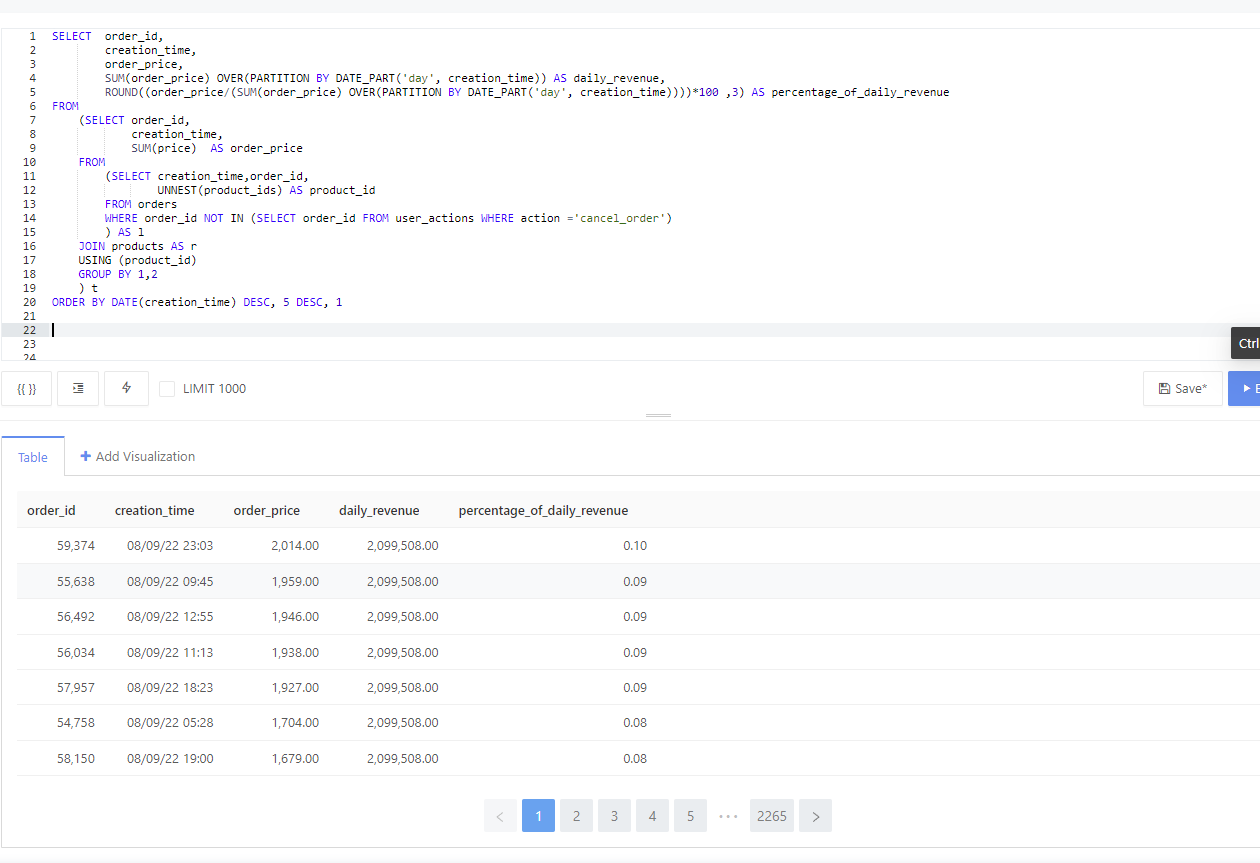

## Задача 15.
Задание:

На основе информации в таблицах orders и products рассчитайте ежедневную выручку сервиса и отразите её в колонке daily_revenue. Затем с помощью оконных функций и функций смещения посчитайте ежедневный прирост выручки. Прирост выручки отразите как в абсолютных значениях, так и в % относительно предыдущего дня. Колонку с абсолютным приростом назовите revenue_growth_abs, а колонку с относительным — revenue_growth_percentage.

Для самого первого дня укажите прирост равным 0 в обеих колонках. При проведении расчётов отменённые заказы не учитывайте. Результат отсортируйте по колонке с датами по возрастанию.

Метрики daily_revenue, revenue_growth_abs, revenue_growth_percentage округлите до одного знака при помощи ROUND().

Поля в результирующей таблице: date, daily_revenue, revenue_growth_abs, revenue_growth_percentage

##### ОТВЕТ:

In [ ]:
# ОШИБКА !!!
SELECT date,
        ROUND(daily_revenue,1) AS daily_revenue,
        CONCAT(ROUND((daily_revenue - lead(daily_revenue, 1) over (ORDER BY date DESC)),1),0.0::DECIMAL) AS revenue_growth_abs,
        CONCAT(ROUND((100*daily_revenue/lead(daily_revenue, 1) over (ORDER BY date DESC)-100),1),0.0::DECIMAL) AS revenue_growth_percentage
FROM
    (SELECT  DISTINCT creation_time::DATE AS date,
            SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue
    FROM 
        (SELECT order_id,
                creation_time,
                SUM(price)  AS order_price
        FROM 
            (SELECT creation_time,order_id,
                    UNNEST(product_ids) AS product_id
            FROM orders
            WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
            ) AS l
        JOIN products AS r
        USING (product_id)
        GROUP BY 1,2
        ) t
    )t2
ORDER BY 1

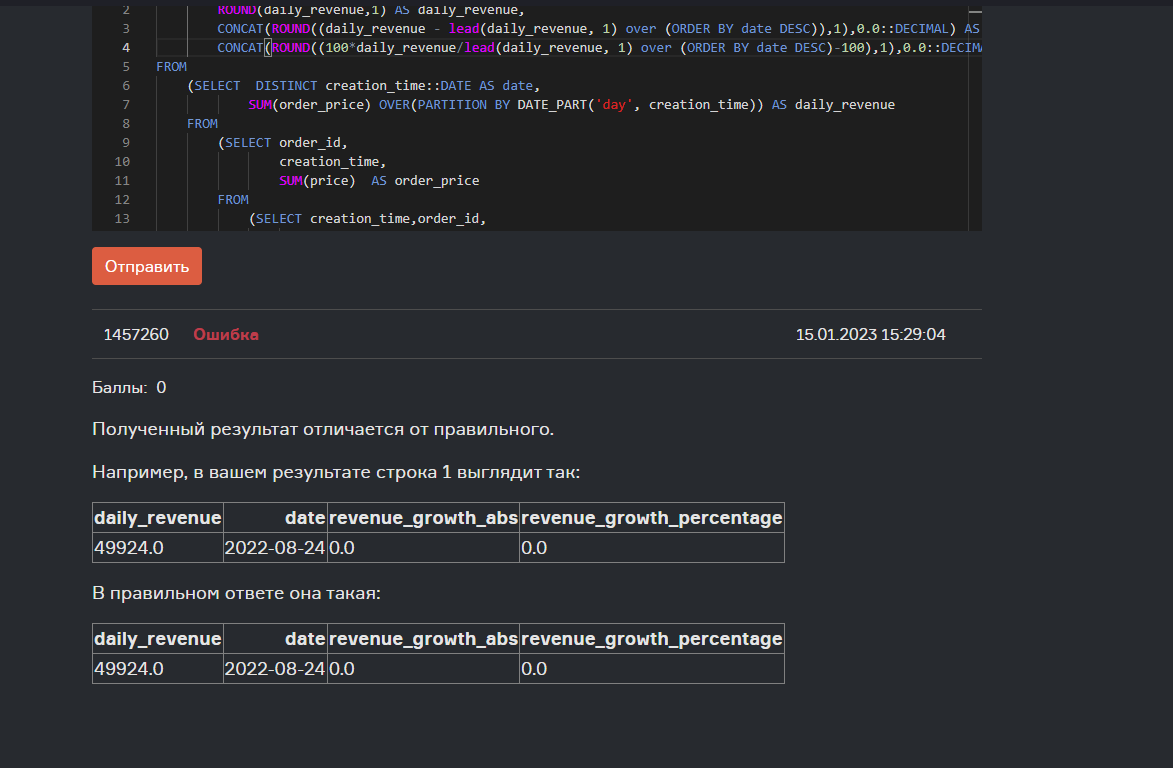

In [ ]:
# ОШИБКА !!!
SELECT date,
        ROUND(daily_revenue,1) AS daily_revenue,
        CONCAT(ROUND((daily_revenue - lead(daily_revenue, 1) OVER (ORDER BY date DESC)),1),0) AS revenue_growth_abs,
        CONCAT(ROUND((100*daily_revenue/lead(daily_revenue, 1) OVER (ORDER BY date DESC)-100),1),0) AS revenue_growth_percentage
FROM
    (SELECT  DISTINCT creation_time::DATE AS date,
            SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue
    FROM 
        (SELECT order_id,
                creation_time,
                SUM(price)  AS order_price
        FROM 
            (SELECT creation_time,order_id,
                    UNNEST(product_ids) AS product_id
            FROM orders
            WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
            ) AS l
        JOIN products AS r
        USING (product_id)
        GROUP BY 1,2
        ) t
    )t2
ORDER BY 1

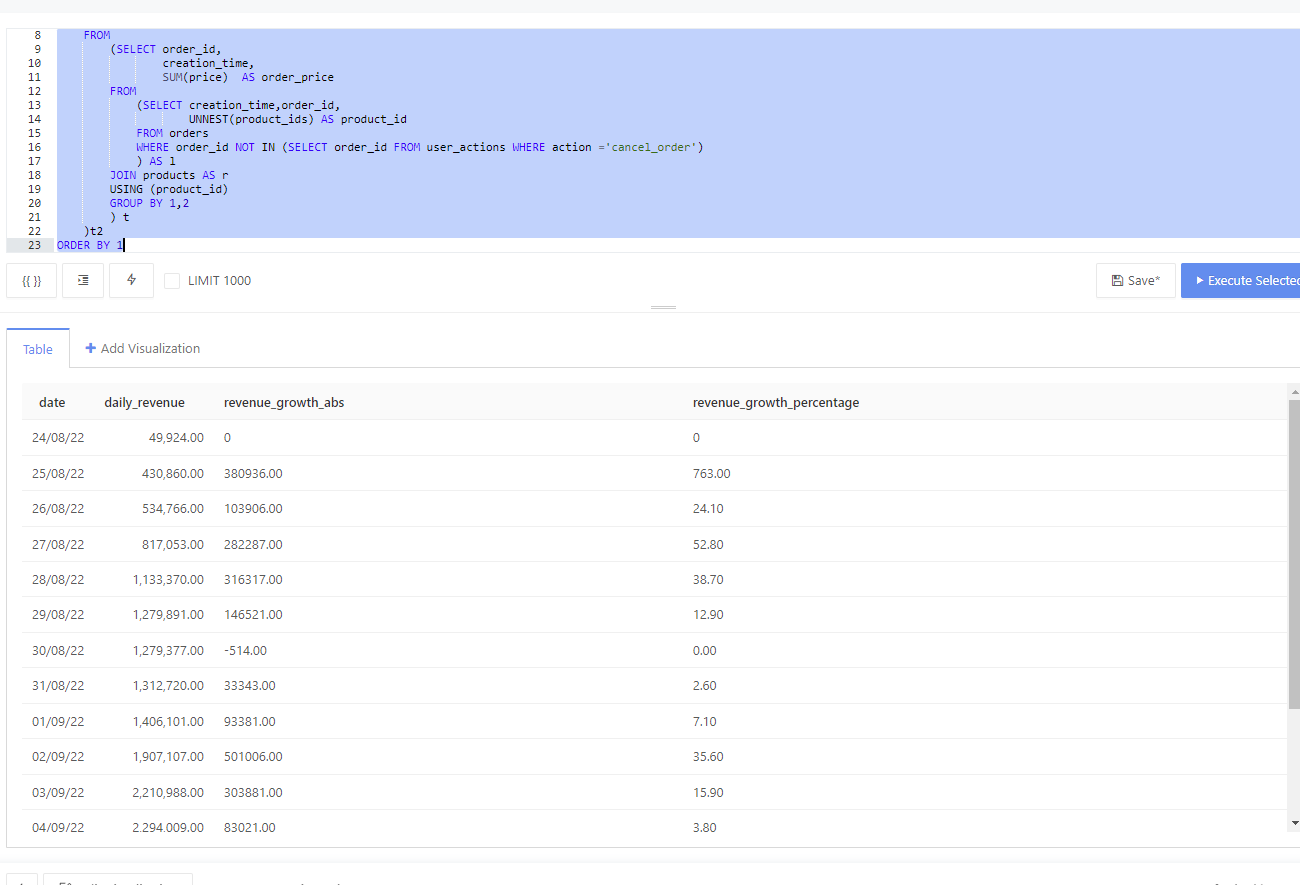

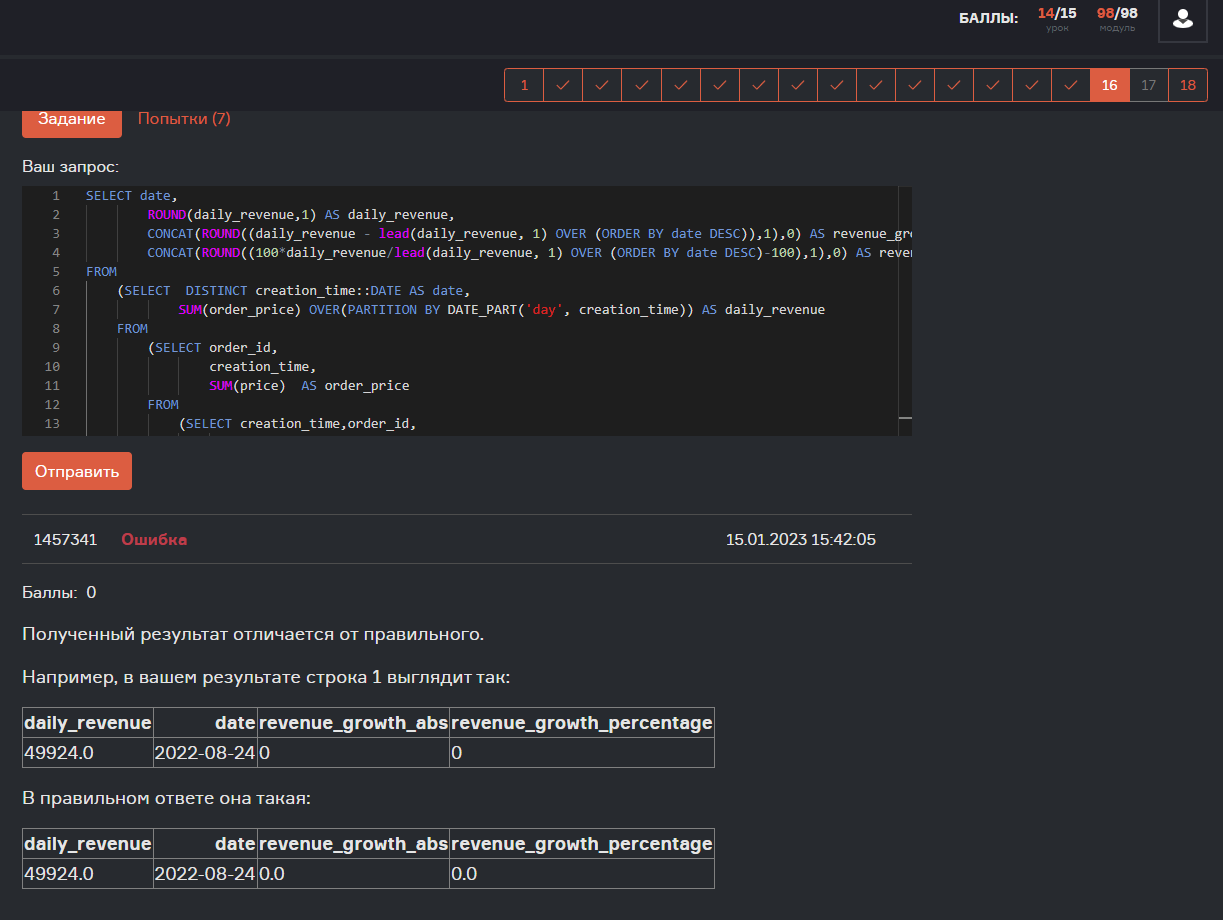

In [ ]:
# МОЕ!!
SELECT date,
        ROUND(daily_revenue,1) AS daily_revenue,
        COALESCE(ROUND((daily_revenue - lead(daily_revenue, 1) OVER (ORDER BY date DESC)),1),0) AS revenue_growth_abs,
        COALESCE(ROUND((100*daily_revenue/lead(daily_revenue, 1) OVER (ORDER BY date DESC)-100),1),0) AS revenue_growth_percentage
FROM
    (SELECT  DISTINCT creation_time::DATE AS date,
            SUM(order_price) OVER(PARTITION BY DATE_PART('day', creation_time)) AS daily_revenue
    FROM 
        (SELECT order_id,
                creation_time,
                SUM(price)  AS order_price
        FROM 
            (SELECT creation_time,order_id,
                    UNNEST(product_ids) AS product_id
            FROM orders
            WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
            ) AS l
        JOIN products AS r
        USING (product_id)
        GROUP BY 1,2
        ) t
    )t2
ORDER BY 1

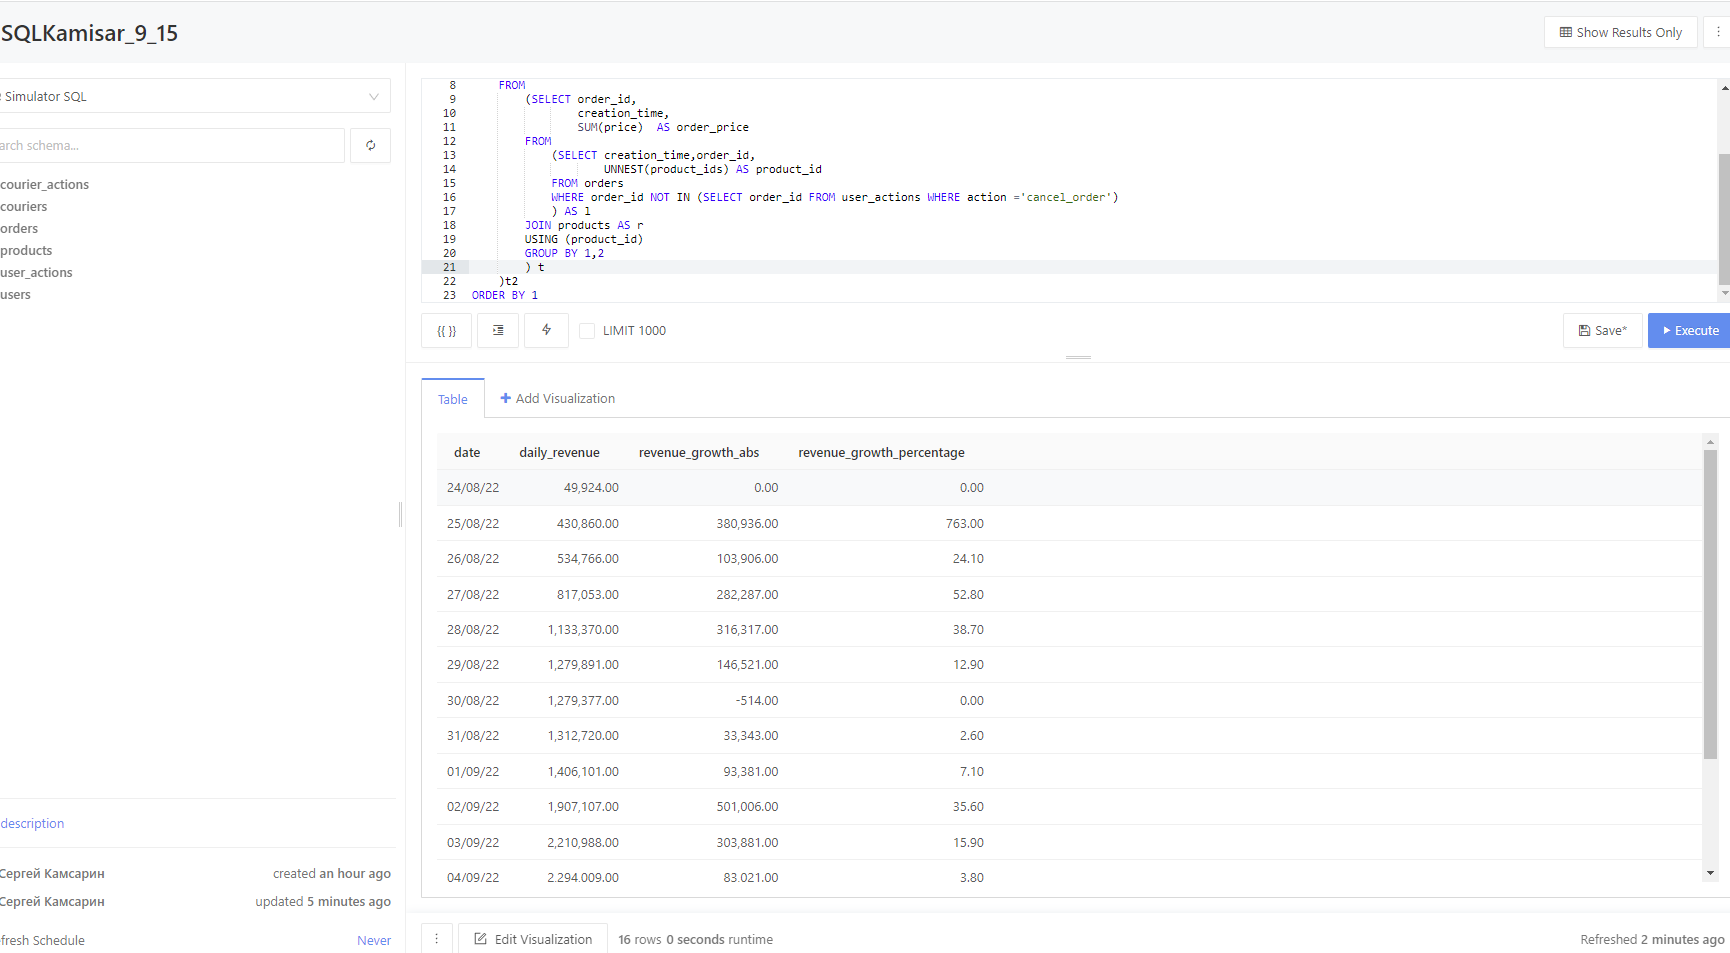

In [ ]:
# Из подсказки после решения
SELECT date,
    round(daily_revenue, 1) as daily_revenue,
    round(COALESCE(daily_revenue - LAG(daily_revenue, 1) OVER (ORDER BY date), 0), 1) AS revenue_growth_abs,
    round(COALESCE(ROUND((daily_revenue - LAG(daily_revenue, 1) OVER (ORDER BY date))::decimal / LAG(daily_revenue, 1) OVER (ORDER BY date) * 100, 2), 0), 1) AS revenue_growth_percentage
FROM ( SELECT DATE(creation_time) AS date,
              SUM(price) AS daily_revenue
              FROM ( SELECT order_id,
                        creation_time,
                        product_ids,
                        UNNEST(product_ids) AS product_id
                    FROM orders WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action='cancel_order')
                   ) t1
              LEFT JOIN products USING(product_id) GROUP BY date
     ) t2
ORDER BY date

## ** Задача 16.
И в конце урока давайте попробуем применить оконные функции для решения нетривиальной задачи.

На практике при расчёте средних значений аналитикам часто приходится иметь дело с экстремально малыми или экстремально большими значениями в выборках. Поэтому вместо обычного среднего иногда приходится считать медиану.

Медиана — это такое значение в некотором упорядоченном по возрастанию наборе чисел, что одна половина элементов набора не меньше него, а другая половина не больше. То есть это такое число, которое находится где-то в середине этого набора. 

Приведём пример. Допустим, у нас есть набор следующих чисел:

1, 5, 2, 12, 17, 8, 50, 12, 9, 1, 3


Если мы упорядочим этот набор по возрастанию, то получим следующий числовой ряд:

1, 1, 2, 3, 5, 8, 9, 12, 12, 17, 50


Давайте пронумеруем элементы упорядоченного набора:

Числовой ряд:
1, 1, 2, 3, 5, 8, 9, 12, 12, 17, 50

Номер элемента:
1, 2, 3, 4, 5, 6, 7,  8,  9, 10, 11  


Теперь хорошо видно, что центральным элементом ряда является число 8 (элемент под номером 6), так как одна половина значений (элементы под номерами 1-5) не больше 8, а вторая половина (элементы под номерами 7-11) не меньше 8. Таким образом, медиана нашего ряда равна 8.

Но это работает, когда ряд состоит из нечётного числа элементов (у нас их 11). Если же в выборке чётное число элементов, тогда в качестве медианы считают среднее значение двух элементов, находящихся в середине ряда.

Давайте добавим в наш ряд число 0 и посмотрим, что в итоге получится:

Числовой ряд:
0, 1, 1, 2, 3, 5, 8, 9, 12, 12, 17, 50

Номер элемента:
1, 2, 3, 4, 5, 6, 7, 8,  9, 10, 11, 12  


Теперь центральными являются числа 5 и 8 (элементы под номерами 6 и 7). Медиана в этом случае равна:

 (5+8)/2=6.5

Вновь одна половина значений (элементы под номерами 1-5) не больше 6.5, а вторая половина (элементы под номерами 7-11) не меньше 6.5.

Бывают случаи, когда в ряде, состоящем из чётного числа элементов, пограничными являются два одинаковых значения. Давайте заменим в нашем ряде число 8 на число 5:

Числовой ряд:
0, 1, 1, 2, 3, 5, 5, 9, 12, 12, 17, 50

Номер элемента:
1, 2, 3, 4, 5, 6, 7, 8,  9, 10, 11, 12  


Теперь медианой будет число 5, поскольку:

(5+5)/2=5

На этом наш небольшой ликбез подходит к концу, и мы возвращаемся к практике.

Задание:

С помощью оконной функции рассчитайте медианную стоимость всех заказов из таблицы orders, оформленных в нашем сервисе. В качестве результата выведите одно число. Колонку с ним назовите median_price. Отменённые заказы не учитывайте.

Поле в результирующей таблице: median_price

Пояснение:

Запрос должен учитывать два возможных сценария: для чётного и нечётного числа заказов. Встроенные функции для расчёта квантилей применять нельзя.

 Подсказка на случай, если совсем не получается
 
 Для расчёта медианы необходимо упорядочить и пронумеровать стоимости заказов, а затем выбрать необходимый элемент/элементы последовательности.

##### ОТВЕТ:

In [ ]:
# Чужое
WITH
    order_list AS (
        SELECT
            o.order_id, 
            SUM(p.price) order_price,
            ROW_NUMBER()
                OVER(ORDER BY SUM(p.price) ASC) order_pos,
            COUNT(o.order_id)
                OVER() total_orders
        FROM (
            SELECT
                order_id,
                unnest(o.product_ids) product_id
            FROM
                orders o
            WHERE
                o.order_id NOT IN (SELECT ua.order_id FROM user_actions ua WHERE ua.action = 'cancel_order')
            ) o
            JOIN products p
                ON p.product_id = o.product_id
        GROUP BY
            o.order_id
    )
SELECT DISTINCT
    CASE 
        WHEN (SELECT COUNT(ol.order_id) FROM order_list ol) % 2 = 1 
            THEN (
                SELECT 
                    ol.order_price median_price
                FROM
                    order_list ol 
                WHERE 
                    ol.order_pos = ((SELECT COUNT(ol.order_id) FROM order_list ol) / 2 + 1)
                )
            ELSE (
                SELECT 
                    ROUND(AVG(ol.order_price), 2) median_price
                FROM
                    order_list ol 
                WHERE 
                    ol.order_pos IN ((SELECT COUNT(ol.order_id) FROM order_list ol) / 2, (SELECT COUNT(ol.order_id) FROM order_list ol) / 2 + 1)
                )
    END median_price
FROM
    order_list ol

In [ ]:
# Из подсказки после решения
WITH main_table AS ( SELECT order_price, ROW_NUMBER() OVER (ORDER BY order_price) AS row_number,
            COUNT(*) OVER() AS total_rows FROM ( SELECT SUM(price) AS order_price
            FROM ( SELECT order_id, product_ids, UNNEST(product_ids) AS product_id 
                    FROM orders WHERE order_id NOT IN (SELECT order_id FROM user_actions
                    WHERE action='cancel_order') 
                    ) t3
                    LEFT JOIN products
                    USING(product_id)
                    GROUP BY order_id )t1
                 )
SELECT AVG(order_price) AS median_price 
FROM main_table
WHERE row_number BETWEEN total_rows/2.0 AND total_rows/2.0 + 1

In [ ]:
# МОЕ !!!
WITH tabl AS (SELECT order_id,
                SUM(price)  AS order_price,
                ROW_NUMBER() OVER(ORDER BY SUM(price)) AS num,
                COUNT(order_id) OVER() AS maximum
        FROM 
            (SELECT creation_time,order_id,
                    UNNEST(product_ids) AS product_id
            FROM orders
            WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ='cancel_order')
            ) AS l
        JOIN products AS r
        USING (product_id)
        GROUP BY 1
        )

SELECT AVG(order_price) AS median_price 
FROM tabl
WHERE num BETWEEN maximum/2.0 AND maximum/2.0 +1


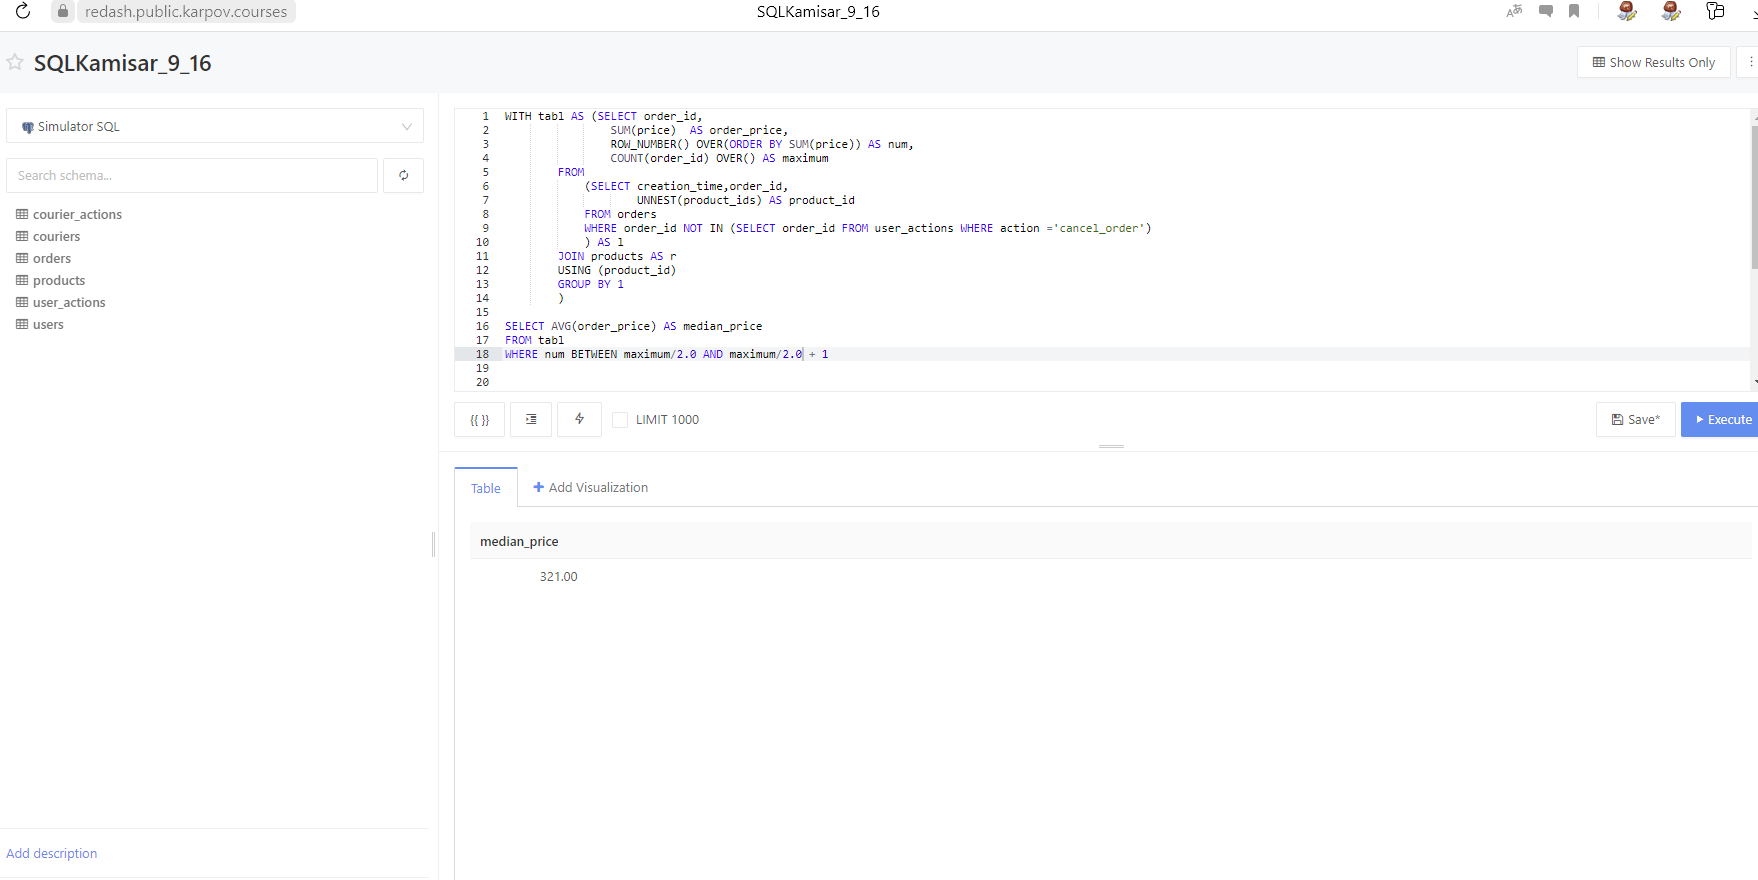

## Подведём итоги
В этом уроке мы:

Научились работать с оконными функциями и проводить сложные аналитические расчёты.
Рассмотрели инструкции PARTITION BY, ORDER BY и ROWS BETWEEN, с помощью которых можно задавать оконные функции и управлять рамкой окна.
Узнали, как вместе с окнами работают агрегирующие и ранжирующие функции, а также функции смещения.
Познакомились с EXTRACT — ещё одной функцией для работы с датами.
Рассмотрели ещё более продвинутый функционал SQL и научились применять оператор FILTER вместе с оконными функциями.
Узнали, как считаются скользящее среднее и медиана, и решили несколько практических задач, с которыми аналитики часто сталкиваются в своей работе.
На этом уроке подходит к концу первый модуль нашего курса, в котором мы подробно рассмотрели весь функционал SQL, необходимый для решения большинства аналитических задач. В следующем модуле мы продолжим оттачивать полученные навыки на ещё более сложных и интересных кейсах — научимся рассчитывать продуктовые метрики, анализировать графики и строить целые дашборды поверх наших запросов.

Stay tuned!

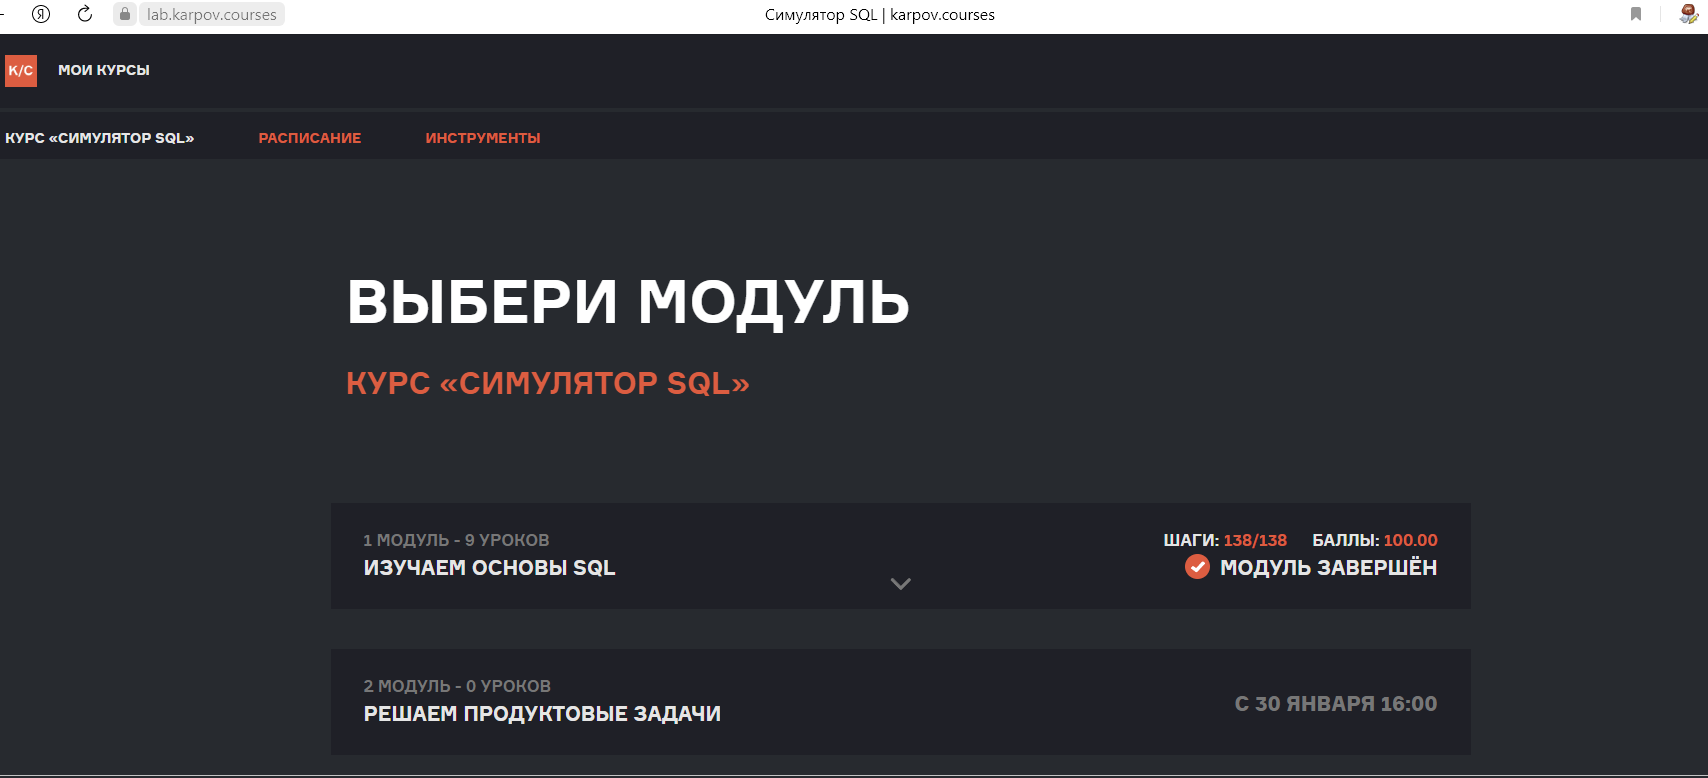